## Settings

In [13]:
# Standard libraries
import os
import re
import gc
import copy
import math
import random
import warnings
import pickle
import shutil
from math import sqrt
from tqdm.notebook import tqdm

# Data processing and analysis
import numpy as np
from numpy.lib.format import open_memmap
import pandas as pd
import vitaldb
import scipy.signal
from scipy import stats
from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt

# Machine learning
import torch
import torch.jit
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
import optuna
import lightgbm as lgb
from sklearn.experimental import enable_iterative_imputer

# Scikit-learn
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

# Explainability
import shap
import ml_insights as mli
import json
from delong import *
from plot_model import *
from utils import setup_logger

# Suppress warnings
warnings.filterwarnings('ignore')

# Clear GPU memory if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Global constants
SEGLEN = 120*80
MAX_CASES = 100
C = 6
CV = 5
SEED = 98
LR = 5e-4
BATCH = 16

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Graph adjacency matrix for EEG channels
adj = torch.zeros(6, 6, dtype=torch.float32)
adj[adj == 0] = 0.5
adj[0, 1] = adj[1, 0] = 1  # L1 <-> L2
adj[0, 4] = adj[4, 0] = 1  # L1 <-> L
adj[1, 4] = adj[4, 1] = 1  # L2 <-> L
adj[2, 3] = adj[3, 2] = 1  # R1 <-> R2
adj[2, 5] = adj[5, 2] = 1  # R1 <-> R
adj[3, 5] = adj[5, 3] = 1  # R2 <-> R
adj += torch.eye(6, dtype=torch.float32)

D = torch.sum(adj, dim=1)
D_sqrt_inv = torch.diag(torch.pow(D, -0.5))
adj = torch.mm(torch.mm(D_sqrt_inv, adj), D_sqrt_inv)
adj = adj.to(device)

features = ['age', 'sex', 'sr_auc', 'sr_duration', 'psi_duration']#
model_configs = {
    'xgb': {'class': xgb.XGBClassifier, 'column': 'y_test_proba_xgb'},
    'et': {'class': ExtraTreesClassifier, 'column': 'y_test_proba_et'},
    'lgb': {'class': lgb.LGBMClassifier, 'column': 'y_test_proba_lgb'},
    'rf': {'class': RandomForestClassifier, 'column': 'y_test_proba_rf'},
    'gb': {'class': GradientBoostingClassifier, 'column': 'y_test_proba_gb'}
}

# Dataset class
class ChunkedDataset(Dataset):
    def __init__(self, X_data, ages, sexes, labels):
        self.X_data = X_data        # Memory-mapped array
        self.ages = ages
        self.sexes = sexes
        self.labels = labels
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        # Get the original index
        # Load just this one sample
        X = torch.tensor(self.X_data[idx], dtype=torch.float32)
        age = torch.tensor([self.ages[idx]], dtype=torch.float32)
        sex = torch.tensor([self.sexes[idx]], dtype=torch.float32)
        label = torch.tensor([self.labels[idx]], dtype=torch.float32)
        return X, age, sex, label

class GraphConvolution(nn.Module):
    """
    Simple GCN layer.
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
        
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return x
    
class CombinedGCNCNN(nn.Module):
    def __init__(self, adj):
        super(CombinedGCNCNN, self).__init__()
        
        nfeat = SEGLEN  
        nhid = 100     
        nclass = SEGLEN 
        dropout = 0.3  

        self.gcn = GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout)
        self.adj = adj
        
        self.conv1 = nn.Conv1d(C, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm1d(32)  
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(64)  
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm1d(128)  
        self.fc1 = nn.Linear(128 * (SEGLEN // 8), 256) 
        self.bn_fc1 = nn.BatchNorm1d(256)  
        self.fc2 = nn.Linear(256+2, 1)
        self.relu = nn.ReLU()
        
        self.embedding_dim = 128
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=4, dim_feedforward=256, dropout=0.2, batch_first=True), 
            num_layers=2)
        
    def forward(self, x, age, sex, adj):
        B, C, L = x.shape
        gcn_x = x.view(B, L, C).permute(0, 2, 1) 
        gcn_out = self.gcn(gcn_x, self.adj)
        gcn_out = gcn_out.view(B, C, L)  
        enhanced_x = x + gcn_out
        x = self.relu(self.conv1(enhanced_x))
        x = self.bn1(x) if B>1 else x
        x = self.relu(self.conv2(x))
        x = self.bn2(x) if B>1 else x
        x = self.relu(self.conv3(x))
        x = self.bn3(x) if B>1 else x
        x = x.permute(0, 2, 1)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.bn_fc1(x) if B>1 else x
        x = self.fc2(torch.cat([x, age, sex], dim=1))
        x = torch.sigmoid(x)
        return x
    
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

def set_seeds(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def youden(y_true, y_score):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    y_true = y_true.ravel()
    y_score = y_score.ravel()
    
    try:
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        if len(thresholds) == 0:
            print("Warning: No thresholds found")
            return 0.5
        J = tpr - fpr
        idx = np.argmax(J)
        return thresholds[idx]
    except Exception as e:
        print(f"Error in Youden calculation: {str(e)}")
        return 0.5

def process_vital_files(dataframe):
    dataframe['sr_auc'] = np.nan
    dataframe['sr_duration'] = np.nan
    dataframe['psi_duration'] = np.nan
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Processing files"):
        filename = row['filename']
        try:
            vf = vitaldb.VitalFile('data_psi/'+str(filename)+'.vital')
            vf2 = vitaldb.VitalFile('data_artf/'+str(filename)+'.vital')
            if 'ROOT/SR' in vf.trks:
                sr = vf.to_numpy('ROOT/SR', 1/vf.trks['ROOT/SR'].srate, return_timestamp=False)
                artf = vf2.to_numpy('ROOT/ARTF', 1/vf2.trks['ROOT/ARTF'].srate, return_timestamp=False)
                if len(sr) > len(artf):
                    artf = np.append(artf, np.full((len(sr) - len(artf), 1), np.nan), axis=0)
                elif len(artf) > len(sr):
                    sr = np.append(sr, np.full((len(artf) - len(sr), 1), np.nan), axis=0)
                mask = artf == 0
                sr = sr[mask]
                ############################
                sr_filtered = sr[(sr > 1) & (sr<100)]
                if len(sr_filtered) > 0:
                    time_step = 1/vf.trks['ROOT/SR'].srate
                    time_filtered = np.arange(len(sr_filtered)) * time_step
                    sr_auc = np.trapz(sr_filtered, x=time_filtered)
                    sr_duration = len(sr_filtered) * time_step
                    dataframe.at[idx, 'sr_auc'] = sr_auc/100
                    dataframe.at[idx, 'sr_duration'] = sr_duration
                else: 
                    dataframe.at[idx, 'sr_auc'] = 0
                    dataframe.at[idx, 'sr_duration'] = 0
            if 'ROOT/PSI' in vf.trks:
                psi = vf.to_numpy('ROOT/PSI', 1/vf.trks['ROOT/PSI'].srate, return_timestamp=False)
                artf = vf2.to_numpy('ROOT/ARTF', 1/vf2.trks['ROOT/ARTF'].srate, return_timestamp=False)
                if len(psi) > len(artf):
                    artf = np.append(artf, np.full((len(psi) - len(artf), 1), np.nan), axis=0)
                elif len(artf) > len(psi):
                    psi = np.append(psi, np.full((len(artf) - len(psi), 1), np.nan), axis=0)
                mask = artf == 0
                psi = psi[mask]
                psi_filtered = psi[(psi < 25)&(psi > 0)]
                if len(psi_filtered) > 0:
                    psi_time_step = 1/vf.trks['ROOT/PSI'].srate
                    psi_duration = len(psi_filtered) * psi_time_step
                    dataframe.at[idx, 'psi_duration'] = psi_duration
                else: 
                    dataframe.at[idx, 'psi_duration'] =0
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    return dataframe

def create_objective_function(model_type, model_class, param_grid_fn):
    def objective(trial, df_train, cv=CV):
        param_grid = param_grid_fn(trial)
        
        h = df_train['hid'].unique()
        groups = np.array(range(len(h)))
        h_shuffled, groups_shuffled = shuffle(h, groups, random_state=SEED)
        
        group_kf = GroupKFold(n_splits=cv)
        cv_scores = np.empty(cv)
        
        for idx, (train_h, val_h) in enumerate(group_kf.split(h_shuffled, groups=groups_shuffled)):
            X_train = df_train[df_train['hid'].isin(h_shuffled[train_h])][features]
            X_valid = df_train[df_train['hid'].isin(h_shuffled[val_h])][features]
            y_train = df_train.loc[df_train['hid'].isin(h_shuffled[train_h]), 'label'].values
            y_valid = df_train.loc[df_train['hid'].isin(h_shuffled[val_h]), 'label'].values
            
            model = model_class(**param_grid)
            
            if model_type == 'xgb':
                model.fit(X_train, y_train, verbose=False)
            else:
                model.fit(X_train, y_train)
                
            cv_scores[idx] = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
        
        mean_cv_score = np.mean(cv_scores)      
        try:
            if mean_cv_score > trial.study.best_value:          
                with open(f'best_params_{model_type}.json', 'w') as f:
                    json.dump(param_grid, f, indent=4)
        except ValueError:
            with open(f'best_params_{model_type}.json', 'w') as f:
                json.dump(param_grid, f, indent=4)
        
        return mean_cv_score
    
    return objective

def xgb_params(trial):
    return {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1600, 200),
        'eta': trial.suggest_float('eta', 0.005, 0.05),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.9),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1, 1e3),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1, 1e3),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 1e3),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1e2),
        'random_state': SEED,
        'enable_categorical': True
    }

def lgb_params(trial):
    return {
        'verbose':-1,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': SEED
    }

def rf_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': SEED
    }

def gb_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'random_state': SEED
    }

def train_fold(X_train, y_train, a_train, s_train, X_val, y_val, a_val, s_val, fold_num):
    train_dataset = ChunkedDataset(X_train, a_train, s_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
    val_dataset = ChunkedDataset(X_val, a_val, s_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)

    train_label_0 = np.sum(y_train[:, None] == 0)
    train_label_1 = np.sum(y_train[:, None] == 1)
    val_label_0 = np.sum(y_val[:, None] == 0)
    val_label_1 = np.sum(y_val[:, None] == 1)

    print(f"Fold {fold_num} - Training set - Label 0: {train_label_0}, Label 1: {train_label_1}")
    print(f"Fold {fold_num} - Validation set - Label 0: {val_label_0}, Label 1: {val_label_1}")

    epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CombinedGCNCNN(adj=adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    criterion = nn.BCELoss()

    best_val_auroc = 0
    patience = 2
    early_stopping_counter = 0
    best_epoch = 0

    for epoch in range(epochs):
        clear_memory()
        model.train()
        running_loss = 0.0
        train_preds = []
        train_targets = []
        train_pbar = tqdm(train_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{epochs} [Train]')
        optimizer.zero_grad()  
    
        for _, (inputs, age, sex, targets) in enumerate(train_pbar):
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            outputs = model(inputs, age, sex, adj)
            bce_loss = criterion(outputs, targets)

            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            
            reg_coef = 0.001
            loss = bce_loss + reg_coef * l2_reg
            loss.backward()

            train_preds.extend(outputs.detach().cpu().numpy())
            train_targets.extend(targets.detach().cpu().numpy())
            running_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

            del inputs, age, sex, targets, outputs, loss, bce_loss, l2_reg
            clear_memory()
            train_pbar.set_postfix({'BCE': f'{running_loss/len(train_preds):.4f}'})
        
        train_preds = np.array(train_preds)
        train_targets = np.array(train_targets)
        train_targets_binary = (train_targets > 0.5).astype(int)
        
        train_metrics = {}
        if len(np.unique(train_targets_binary)) == 2:
            train_metrics['auroc'] = roc_auc_score(train_targets_binary, train_preds)
            train_metrics['auprc'] = average_precision_score(train_targets_binary, train_preds)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{epochs} [Val]')
            for inputs, age, sex, targets in val_pbar:
                inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
                outputs = model(inputs, age, sex, adj)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_targets.extend(targets.detach().cpu().numpy())
                val_pbar.set_postfix({'BCE': f'{loss.item():.4f}'})
        
        val_preds = np.array(val_preds)
        val_targets = np.array(val_targets)
        val_targets_binary = val_targets
        
        val_metrics = {}
        if len(np.unique(val_targets_binary)) == 2:
            val_metrics['auroc'] = roc_auc_score(val_targets_binary, val_preds)
            val_metrics['auprc'] = average_precision_score(val_targets_binary, val_preds)
        
        epoch_val_loss = val_loss/len(val_loader)
        print(f"Fold {fold_num} - Epoch {epoch+1}/{epochs}")
        print(f"Train - BCE Loss: {running_loss/len(train_preds):.4f}, AUROC: {train_metrics.get('auroc', 0):.4f}, AUPRC: {train_metrics.get('auprc', 0):.4f}")
        print(f"Val   - BCE Loss: {epoch_val_loss:.4f}, AUROC: {val_metrics.get('auroc', 0):.4f}, AUPRC: {val_metrics.get('auprc', 0):.4f}")
        
        if val_metrics and (epoch == 0 or val_metrics['auroc'] > best_val_auroc):
            best_val_auroc = val_metrics['auroc']
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            early_stopping_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auroc': best_val_auroc,
                'train_metrics': train_metrics,
                'val_metrics': val_metrics
            }, f'best_model_fold_{fold_num}.pth')
            print(f"New best model saved with validation AUROC: {best_val_auroc:.4f}")
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs. No improvement in validation AUROC for {patience} epochs.")
            break
    steps_per_epoch = len(train_loader)
    total_steps = (best_epoch + 1) * steps_per_epoch
    print(f"Fold {fold_num} training completed. Best validation AUROC: {best_val_auroc:.4f} at epoch {best_epoch+1}")
    print(f"Step size for fold {fold_num}: {total_steps}")
    return total_steps

def extract_frequency_bands(eeg_data, sampling_rate=SEGLEN/120):
    eeg_np = eeg_data.detach().cpu().numpy()
    n_channels, n_samples = eeg_np.shape
    bands = {
        "Noise": (0.5,1),
        "Delta": (1,4),
        "Theta": (4,8),
        "Alpha": (8, 12),
        "High": (12,40-10e-10),
        "Total_plus":(0.5,40-10e-10),
        "Total": (1, 40-10e-10)
    }
    freqs, psd = scipy.signal.welch(eeg_np, fs=sampling_rate, 
                                   nperseg=160,noverlap=120, scaling='density',
                                   axis=1)
    results = {'absolute': {}, 'relative': {}, 'timeseries': {}}

    band_powers = {}
    for band, (f_low, f_high) in bands.items():
        idx = np.logical_and(freqs >= f_low, freqs <= f_high)
        band_power = np.trapz(psd[:,idx], freqs[idx], axis=1).sum()
        band_powers[band] = band_power

    for band in ["Delta", "Theta", "Alpha"]:
        power = 10 * np.log10(band_powers[band])
        rel_power = band_powers[band]/band_powers["Total"]
        results[band] = torch.tensor(power, dtype=torch.float32)
        results['relative'][band]= torch.tensor(rel_power, dtype=torch.float32)
    for band in ["Noise","High"]:
        power = 10 * np.log10(band_powers[band])
        rel_power = band_powers[band]/band_powers["Total_plus"]
        results[band] = torch.tensor(power, dtype=torch.float32)
        results['relative'][band]= torch.tensor(rel_power, dtype=torch.float32)        
    return results

def calculate_regression_with_ci(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    n = len(x)
    mean_x = np.mean(x)
    ss_x = np.sum((x - mean_x)**2)
    se = np.sqrt(np.sum((y - (slope * x + intercept))**2) / (n - 2))
    se_slope = se / np.sqrt(ss_x)
    se_intercept = se * np.sqrt(1/n + mean_x**2/ss_x)
    t_value = stats.t.ppf(0.975, n-2)
    ci_slope = (slope - t_value * se_slope, slope + t_value * se_slope)
    ci_intercept = (intercept - t_value * se_intercept, intercept + t_value * se_intercept)
    x_min, x_max = np.min(x), np.max(x)
    x_line = np.linspace(x_min, x_max, 100)
    y_line = slope * x_line + intercept
    se_y_pred = se * np.sqrt(1/n + (x_line - mean_x)**2 / ss_x)
    y_lower = y_line - t_value * se_y_pred
    y_upper = y_line + t_value * se_y_pred
    return {
        'slope': slope, 
        'intercept': intercept, 
        'ci_slope': ci_slope, 
        'ci_intercept': ci_intercept,
        'x_line': x_line, 
        'y_line': y_line, 
        'y_lower': y_lower, 
        'y_upper': y_upper
    }

def run_frequency_analysis(model_path, test_file='test_ids.npy', SEGNUM=10):
    X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
    Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
    ID = np.load('C_f.npy', mmap_mode='r')
    FILE = np.load('F_f.npy', mmap_mode='r')
    A = np.load('A_f.npy', mmap_mode='r')
    S = np.load('S_f.npy', mmap_mode='r')
    checkpoint = torch.load(model_path, map_location=device)
    model = CombinedGCNCNN(adj=adj).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    del checkpoint
    test_ids = np.load(test_file, allow_pickle=True)
    test_mask = np.isin(ID, test_ids)
    X_test = X_normalized[test_mask] 
    y_test = Y_normalized[test_mask]
    a_test = A[test_mask]
    s_test = S[test_mask]
    id_test = FILE[test_mask]
    del X_normalized, Y_normalized, A, S, test_mask
    channel_names = ["L1", "L2", "R1", "R2", "L", "R"]
    batch_size = 16
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
    sample_data = {
        'id': [],
        'prob': [],
        'Delta': [],
        'Theta': [],
        'Alpha': [],
        'relative_Delta': [],
        'relative_Theta': [],
        'relative_Alpha': []
    }
    for i in tqdm(range(0, len(X_test), batch_size), desc="Processing test data"):
        batch_indices = list(range(i, min(i+batch_size, len(X_test))))
        x_batch = torch.tensor(X_test[batch_indices], dtype=torch.float32).to(device)
        age_batch = torch.tensor(a_test[batch_indices], dtype=torch.float32).unsqueeze(1).to(device)
        sex_batch = torch.tensor(s_test[batch_indices], dtype=torch.float32).unsqueeze(1).to(device)
        with torch.no_grad():
            batch_preds = model(x_batch, age_batch, sex_batch, adj)
        
        for j, idx in enumerate(batch_indices):
            batch_idx = j
            true_label = y_test[idx]
            pred = batch_preds[batch_idx].item()
            sample_id = id_test[idx]
            
            x_sample = torch.tensor(X_test[idx], dtype=torch.float32).unsqueeze(0).to(device)
            frequency_bands = extract_frequency_bands(x_sample.squeeze(0))
            
            sample_data['id'].append(sample_id)
            sample_data['prob'].append(pred)
            
            for band_name in ['Delta', 'Theta', 'Alpha']:
                if band_name in frequency_bands:
                    sample_data[band_name].append(frequency_bands[band_name].item())
                    
                    rel_band_data = frequency_bands['relative'][band_name]
                    rel_band_mean = torch.mean(rel_band_data).item()
                    sample_data[f'relative_{band_name}'].append(rel_band_mean)
        del x_batch, age_batch, sex_batch, batch_preds
    
    # Ensure all lists in sample_data have the same length
    min_length = min(len(sample_data[key]) for key in sample_data)
    for key in sample_data:
        sample_data[key] = sample_data[key][:min_length]
        
    df = pd.DataFrame(sample_data)
    grouped_data = df.groupby('id').mean().reset_index()
    
    for i, band_name in enumerate(['Delta', 'Theta', 'Alpha']):
        col_name = f"relative_{band_name}"
        if col_name in grouped_data.columns:
            axes[0, i].scatter(grouped_data['prob'], grouped_data[col_name], s=1)
            r, p = stats.spearmanr(grouped_data['prob'], grouped_data[col_name])
            reg_results = calculate_regression_with_ci(grouped_data['prob'], grouped_data[col_name])
            x_line = np.linspace(0, 1, 100)
            y_line = reg_results['slope'] * x_line + reg_results['intercept']
            n = len(grouped_data['prob'])
            mean_x = np.mean(grouped_data['prob'])
            ss_x = np.sum((grouped_data['prob'] - mean_x)**2)
            se = np.sqrt(np.sum((grouped_data[col_name] - (reg_results['slope'] * grouped_data['prob'] + reg_results['intercept']))**2) / (n - 2))
            t_value = stats.t.ppf(0.975, n-2)
            se_y_pred = se * np.sqrt(1/n + (x_line - mean_x)**2 / ss_x)
            y_lower = y_line - t_value * se_y_pred
            y_upper = y_line + t_value * se_y_pred
            axes[0, i].plot(x_line, y_line, 'r-', lw=0.8)
            axes[0, i].fill_between(x_line, y_lower, y_upper, color='red', alpha=0.1)
            print(f"{band_name} relative")
            print(f"Spearman's ρ={r:.3f}, p={p:.3f}")
            print(f"β={reg_results['slope']:.3f} [{reg_results['ci_slope'][0]:.3f}, {reg_results['ci_slope'][1]:.3f}], α={reg_results['intercept']:.3f} [{reg_results['ci_intercept'][0]:.3f}, {reg_results['ci_intercept'][1]:.3f}]")
            axes[0, i].set_ylim(0, 0.65)
            axes[0, i].set_xlabel('Prediction Probability of DELPHI-EEG')
            axes[0, i].set_ylabel(f'{band_name} Wave Relative Band Power')
            axes[0, i].grid(True, alpha=0.3)
        else:
            axes[0, i].set_visible(False)
    for i in range(3):
        axes[1, i].set_visible(False)
    plt.show()
    del X_test, y_test, a_test, s_test, id_test, ID

def evaluate_model(model, data_loader, device, youden_threshold, calib):
    model.eval()
    test_preds_all_models = []
    test_targets = []
    with torch.no_grad():
        test_pbar = tqdm(data_loader, desc=f'[Test]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            model.eval()
            outputs = model(inputs, age, sex, adj)
            test_preds_all_models.extend(outputs.detach().cpu().numpy())
            test_targets.extend(targets.detach().cpu().numpy())
    test_preds = np.array(test_preds_all_models).ravel()
    test_targets = np.array(test_targets)
    test_preds = calib.calibrate(test_preds)
    y_pred_test = (test_preds > youden_threshold).astype(int)
    class1_f1 = f1_score(test_targets, y_pred_test)
    
    return class1_f1

## EEG Preprocessing

In [ ]:
x2= pd.read_csv('delirium_old.csv', encoding='cp949', encoding_errors='ignore')
x1= pd.read_csv('eeg_rid_supreme_sampled.csv')
sex_mapping = dict(zip(x2['연구별 환자 ID'], x2['성별']))
x1['sex'] = x1['hid'].map(sex_mapping)
x1['sex'] = x1['sex'].map({'M': 1, 'F': 0})

chs = ['ROOT/EEG_L1', 'ROOT/EEG_L2', 'ROOT/EEG_R1', 'ROOT/EEG_R2', 'ROOT/EEG_L', 'ROOT/EEG_R']
x_list = []
y_list = []
c_list = []
f_list = []
a_list = []
s_list = []
p_list = []

new_srate =SEGLEN/120
for idx in tqdm(range(len(x1))):
    try:
        vf = vitaldb.VitalFile('data/'+x1.loc[idx,'filename']+'.vital')
            
        wf_list = []
        for ch in chs:
            wf_single_orig = vf.to_numpy(ch, 1/vf.trks[ch].srate, return_timestamp=False)
            t_orig = np.arange(len(wf_single_orig)) / vf.trks[ch].srate
            
            t_new = np.arange(0, t_orig[-1], 1/new_srate)
            
            wf_single = np.interp(t_new, t_orig, wf_single_orig.ravel())
            wf_list.append(wf_single)
            
            del wf_single_orig, t_orig, t_new, wf_single
            
        wf = np.column_stack(wf_list)
        del wf_list

        try:
            psi_raw = vf.to_numpy('ROOT/SR', 1/vf.trks['ROOT/SR'].srate, return_timestamp=False).ravel()
            t_orig = np.arange(len(psi_raw)) / vf.trks['ROOT/SR'].srate
            t_new = np.linspace(0, t_orig[-1], len(wf))
            psi = np.interp(t_new, t_orig, psi_raw)
            del psi_raw, t_orig, t_new
        except:
            psi = np.full(len(wf), np.nan)

        srate = new_srate
        window_size = int(srate*120)
        
        total_mean = np.nanmean(wf)
        total_std = np.nanstd(wf)

        best_chunks = []
        best_psi_chunks = []
        best_z_scores = []
        
        stride = int(srate*40)
        for i in range(0, len(wf) - window_size + 1, stride):
            EXTRACT_SIZE =30
            chunk = wf[i:i+window_size]
            psi_chunk = np.nanmean(psi[i:i+window_size])
            if not np.isnan(chunk).any():
                chunk_mean = np.mean(chunk)
                z_score = abs((chunk_mean - total_mean) / total_std)
                
                if len(best_chunks) < EXTRACT_SIZE:
                    best_chunks.append(chunk)
                    best_z_scores.append(z_score)
                    best_psi_chunks.append(psi_chunk)
                    if (len(best_chunks) == EXTRACT_SIZE) | (i==(len(wf) - window_size - ((len(wf) - window_size) % stride))):
                        indices = np.argsort(best_z_scores)
                        best_chunks = [best_chunks[i] for i in indices]
                        best_z_scores = [best_z_scores[i] for i in indices]
                        best_psi_chunks = [best_psi_chunks[i] for i in indices]
                        if i==(len(wf) - window_size - ((len(wf) - window_size) % stride)):
                            EXTRACT_SIZE = len(best_chunks)
                elif z_score < best_z_scores[-1]:
                    best_chunks[-1] = chunk
                    best_z_scores[-1] = z_score
                    best_psi_chunks[-1] = psi_chunk
                    indices = np.argsort(best_z_scores)
                    best_chunks = [best_chunks[i] for i in indices]
                    best_z_scores = [best_z_scores[i] for i in indices]
                    best_psi_chunks = [best_psi_chunks[i] for i in indices]
                
                del chunk_mean, z_score
            elif (i==(len(wf) - window_size - ((len(wf) - window_size) % stride))):
                indices = np.argsort(best_z_scores)
                best_chunks = [best_chunks[i] for i in indices]
                best_z_scores = [best_z_scores[i] for i in indices]
                best_psi_chunks = [best_psi_chunks[i] for i in indices]
                EXTRACT_SIZE = len(best_chunks)

        selected_chunks = np.array(best_chunks)
        selected_psi_chunks = np.array(best_psi_chunks)
        if selected_chunks.shape[1] != int(new_srate*120):
            del selected_chunks, selected_psi_chunks, best_chunks, best_psi_chunks, best_z_scores, wf, psi, vf
            continue
        if selected_chunks.shape[0] != EXTRACT_SIZE:
            print(f"PROBLEM, {selected_chunks.shape[0]}, {EXTRACT_SIZE}, {i}, {(len(wf) - window_size - ((len(wf) - window_size) % stride))}")
        x_list.append(selected_chunks.astype(np.float32))
        p_list.append(selected_psi_chunks)
        
        new_labels = np.array([x1.loc[idx,'label']] * EXTRACT_SIZE)
        new_hids = np.array([x1.loc[idx,'hid']] * EXTRACT_SIZE)
        new_files = np.array([x1.loc[idx,'filename']] * EXTRACT_SIZE)
        new_ages = np.array([x1.loc[idx,'age']] * EXTRACT_SIZE)
        new_sexes = np.array([x1.loc[idx,'sex']] * EXTRACT_SIZE)
        
        y_list.append(new_labels)
        c_list.append(new_hids)
        f_list.append(new_files)
        a_list.append(new_ages)
        s_list.append(new_sexes)
            
        del selected_chunks, selected_psi_chunks, best_chunks, best_psi_chunks
        del best_z_scores, wf, psi, vf, new_labels, new_hids, new_files
        del new_ages, new_sexes
        
    except FileNotFoundError:
        print(f"File not found: {x1.loc[idx,'filename']}")  
        continue
    except Exception as e:
        continue

if len(x_list) > 0:
    x = np.vstack(x_list)
    p = np.concatenate(p_list)
    y = np.concatenate(y_list)
    c = np.concatenate(c_list)
    f = np.concatenate(f_list)
    a = np.concatenate(a_list)
    s = np.concatenate(s_list)
else:
    x = np.array([])
    p = np.array([])
    y = np.array([])
    c = np.array([])
    f = np.array([])
    a = np.array([])
    s = np.array([])

x = np.transpose(x, (0, 2, 1))
np.save('X.npy', x)
np.save('Y.npy', y)
np.save('C.npy', c)
np.save('F.npy', f)
np.save('A.npy', a)
np.save('S.npy', s)
np.save('P.npy', p)
print(f"Saved arrays with shapes: X:{x.shape}, Y:{y.shape}, C:{c.shape}, A:{a.shape}, S:{s.shape}, F:{f.shape}, P:{p.shape}")

In [ ]:
X = np.load('X.npy', mmap_mode='r')
X_normalized = open_memmap('X_normalized.npy', dtype='float32', 
                          mode='w+', shape=X.shape)
ID = np.load('C.npy', mmap_mode='r')
train_ids = np.load('train_ids_5.npy', allow_pickle=True)
train_mask = np.isin(ID, train_ids)
X_train = X[train_mask]

X_mean = np.mean(X_train, dtype=np.float32)
X_std = np.float64(0)
for i in tqdm(range(0, len(X_train), 1000), desc="Calculating X std"):
    batch = X_train[i:i+1000].astype(np.float32)
    X_std += np.sum((batch - X_mean) ** 2, dtype=np.float64)
X_std = np.sqrt(X_std / (len(X_train) - 1)).astype(np.float32)

for i in tqdm(range(0, len(X), 1000), desc="Normalizing X"):
    batch = X[i:i+1000].astype(np.float32)
    normalized_batch = (batch - X_mean) / X_std
    X_normalized[i:i+1000] = normalized_batch
    X_normalized.flush()
    del batch, normalized_batch
del X_normalized 

In [ ]:
X_normalized = np.load('X_normalized.npy', mmap_mode='r')
Y_normalized = np.load('Y.npy', mmap_mode='r')
ID = np.load('C.npy', mmap_mode='r')
FILE = np.load('F.npy', mmap_mode='r')
A = np.load('A.npy', mmap_mode='r')
S = np.load('S.npy', mmap_mode='r')
P = np.load('P.npy', mmap_mode='r')
P = P.flatten()

print("Original data shapes:", X_normalized.shape, Y_normalized.shape)
print("Checking for uniform channels...")

valid_samples = []
total_samples = X_normalized.shape[0]

for i in tqdm(range(total_samples)):
    has_uniform_channel = False
    for channel in range(X_normalized.shape[1]):
        if np.all(X_normalized[i, channel, :] == X_normalized[i, channel, 0]):
            has_uniform_channel = True
            break
    
    if not has_uniform_channel:
        valid_samples.append(i)

valid_samples = np.array(valid_samples)
X_normalized_filtered = X_normalized[valid_samples]
Y_normalized_filtered = Y_normalized[valid_samples]
ID_filtered = ID[valid_samples]
FILE_filtered = FILE[valid_samples]
A_filtered = A[valid_samples]
S_filtered = S[valid_samples]
P_filtered = P[valid_samples]

print(f"Removed {total_samples - len(valid_samples)} samples with uniform channels")
print(f"Remaining samples: {len(valid_samples)}")
print(f"New shapes: X:{X_normalized_filtered.shape}, Y:{Y_normalized_filtered.shape}")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

lowcut = 0.5
highcut = 40.0 - 10e-10
fs = 80.0
order = 5

print("Applying bandpass filter (0.5Hz to 40Hz) to data...")
X_filtered = np.zeros_like(X_normalized_filtered)

for i in tqdm(range(X_normalized_filtered.shape[0])):
    for channel in range(X_normalized_filtered.shape[1]):
        X_filtered[i, channel, :] = apply_bandpass_filter(
            X_normalized_filtered[i, channel, :], 
            lowcut, 
            highcut, 
            fs, 
            order
        )

print("Bandpass filtering complete.")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

np.save('X_normalized_f.npy', X_filtered)
np.save('Y_normalized_f.npy', Y_normalized_filtered)
np.save('C_f.npy', ID_filtered)
np.save('F_f.npy', FILE_filtered)
np.save('A_f.npy', A_filtered)
np.save('S_f.npy', S_filtered)
np.save('P_f.npy', P_filtered)

## DELPHI-EEG

In [ ]:
# Training
set_seeds()

train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r').astype(np.float32)
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

train_mask = np.isin(ID, train_ids)
X_train_full = X_normalized[train_mask]
y_train_full = Y_normalized[train_mask]    
a_train_full = A[train_mask]
s_train_full = S[train_mask]
ID_train_full = ID[train_mask]
FILE_train_full = FILE[train_mask]

del X_normalized
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

unique_ids = np.unique(ID_train_full)
print(f"Total unique IDs: {len(unique_ids)}")
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
fold_step_sizes = []

fold_num = 1
for train_idx, val_idx in kf.split(unique_ids):
    print(f"\n{'='*20} Fold {fold_num} {'='*20}")
    
    fold_train_ids = unique_ids[train_idx]
    fold_val_ids = unique_ids[val_idx]
    
    fold_train_mask = np.isin(ID_train_full, fold_train_ids)
    fold_val_mask = np.isin(ID_train_full, fold_val_ids)
    
    X_fold_train = X_train_full[fold_train_mask]
    y_fold_train = y_train_full[fold_train_mask]
    a_fold_train = a_train_full[fold_train_mask]
    s_fold_train = s_train_full[fold_train_mask]
    
    X_fold_val = X_train_full[fold_val_mask]
    y_fold_val = y_train_full[fold_val_mask]
    a_fold_val = a_train_full[fold_val_mask]
    s_fold_val = s_train_full[fold_val_mask]
    
    step_size = train_fold(
        X_fold_train, y_fold_train, a_fold_train, s_fold_train,
        X_fold_val, y_fold_val, a_fold_val, s_fold_val,
        fold_num
    )
    fold_step_sizes.append(step_size)
    fold_num += 1


mean_step_size = int(np.mean(fold_step_sizes))
print(f"\nStep sizes for each fold: {fold_step_sizes}")
print(f"Mean step size: {mean_step_size}")
print(f"\n{'='*20} Training on Full Dataset {'='*20}")

full_train_dataset = ChunkedDataset(X_train_full, a_train_full, s_train_full, y_train_full)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH, shuffle=True)
full_train_label_0 = np.sum(y_train_full[:, None] == 0)
full_train_label_1 = np.sum(y_train_full[:, None] == 1)
print(f"Full training set - Label 0: {full_train_label_0}, Label 1: {full_train_label_1}")
steps_per_epoch = len(full_train_loader)
epochs_to_train = max(1, mean_step_size // steps_per_epoch)
remaining_steps = mean_step_size % steps_per_epoch

print(f"Training for {epochs_to_train} epochs and {remaining_steps} additional steps")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = CombinedGCNCNN(adj=adj).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.BCELoss()
final_model.train()
step_counter = 0
early_stop = False

for epoch in range(epochs_to_train + 1):
    if early_stop:
        break
    train_pbar = tqdm(full_train_loader, desc=f'Full Training - Epoch {epoch+1}/{epochs_to_train+1}')
    running_loss = 0.0
    
    for batch_idx, (inputs, age, sex, targets) in enumerate(train_pbar):
        if step_counter >= mean_step_size:
            early_stop = True
            break
            
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs, age, sex, adj)
        
        bce_loss = criterion(outputs, targets)
        l2_reg = 0.0
        for param in final_model.parameters():
            l2_reg += torch.norm(param, 2)
        
        reg_coef = 0.001
        loss = bce_loss + reg_coef * l2_reg
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step_counter += 1
        if epoch == epochs_to_train and batch_idx >= remaining_steps - 1:
            early_stop = True
            break
        train_pbar.set_postfix({'BCE': f'{running_loss/(batch_idx+1):.4f}', 'Step': f'{step_counter}/{mean_step_size}'})

#Step sizes for each fold: [2526, 6245, 8757, 5048, 2504]
#Mean step size: 5016
torch.save({
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'steps_trained': step_counter,
    'mean_step_size': mean_step_size
}, 'final_model_full_training.pth')


[Train]:   0%|          | 0/1570 [00:00<?, ?it/s]

Youden Index : 0.067
Test set - Label 0: 62627, Label 1: 422


[Test]:   0%|          | 0/3941 [00:00<?, ?it/s]

AUROC 0.869 (95% CI: 0.791-0.936)
AUPRC 0.037 (95% CI: 0.018-0.082)
F1 Score 0.026 (95% CI: 0.013-0.040)
Test Accuracy 0.550 (95% CI: 0.531-0.570)
Brier Score 0.030 (95% CI: 0.027-0.034)
ICI 0.106 (95% CI: 0.100-0.112)


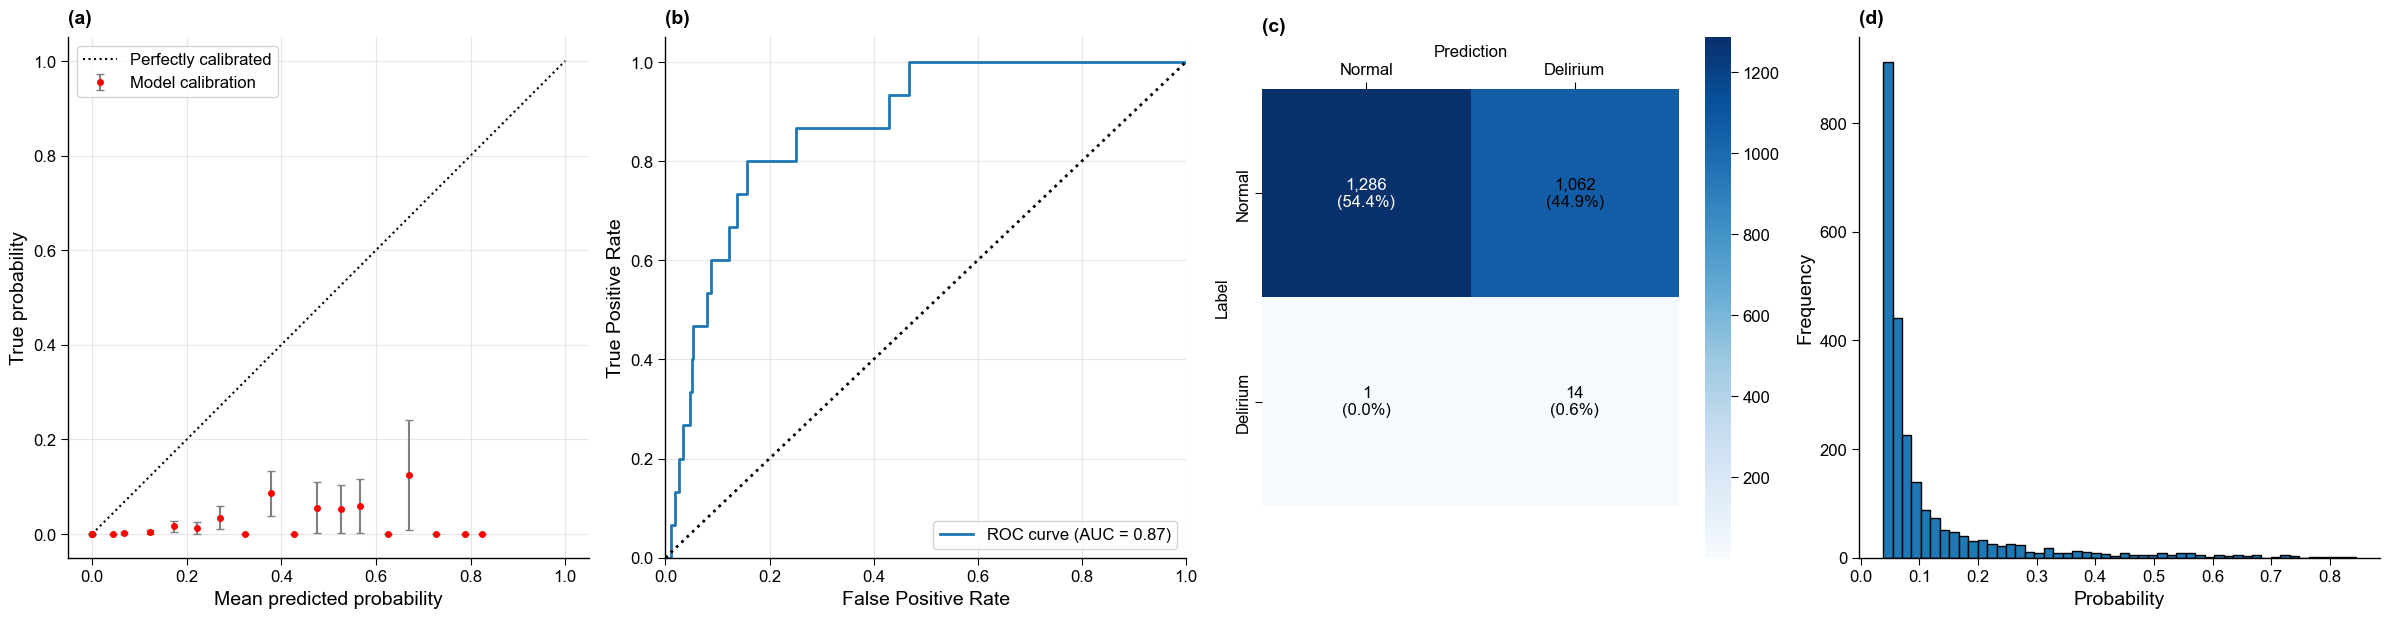

Test set - Label 0: 345, Label 1: 422


[Test]:   0%|          | 0/48 [00:00<?, ?it/s]

AUROC 0.883 (95% CI: 0.739-0.983)
AUPRC 0.915 (95% CI: 0.783-0.989)
F1 Score 0.824 (95% CI: 0.667-0.944)
Test Accuracy 0.778 (95% CI: 0.630-0.926)
Brier Score 0.285 (95% CI: 0.173-0.403)
ICI 0.363 (95% CI: 0.263-0.507)


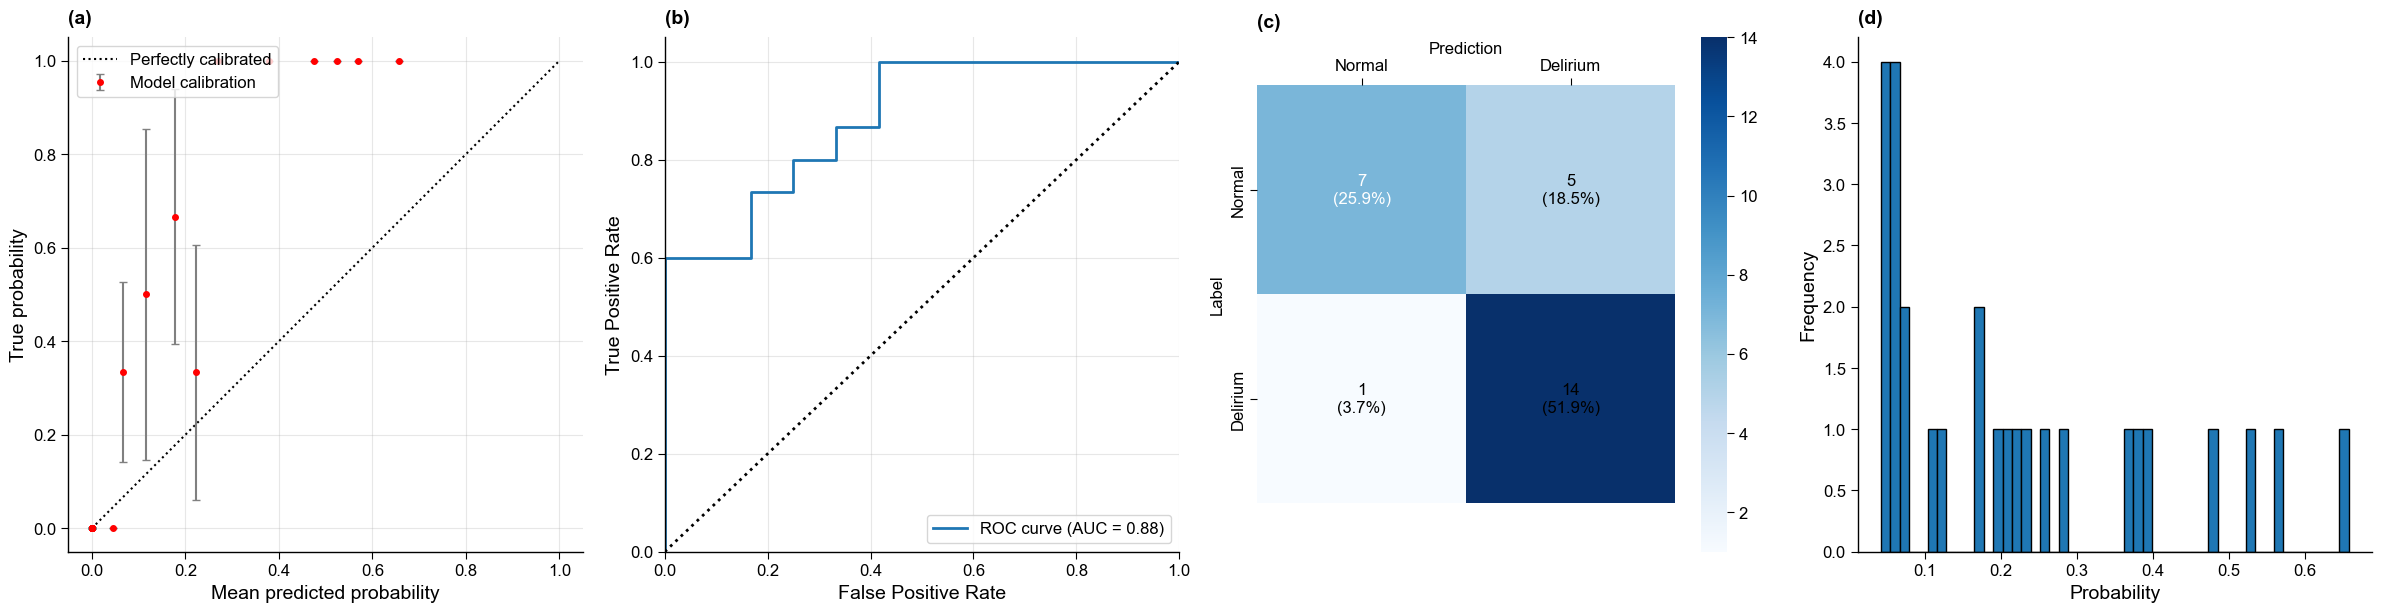

Test set - Label 0: 872, Label 1: 422


[Test]:   0%|          | 0/81 [00:00<?, ?it/s]

AUROC 0.927 (95% CI: 0.839-0.989)
AUPRC 0.884 (95% CI: 0.732-0.977)
F1 Score 0.700 (95% CI: 0.500-0.844)
Test Accuracy 0.755 (95% CI: 0.633-0.878)
Brier Score 0.160 (95% CI: 0.086-0.235)
ICI 0.237 (95% CI: 0.158-0.324)


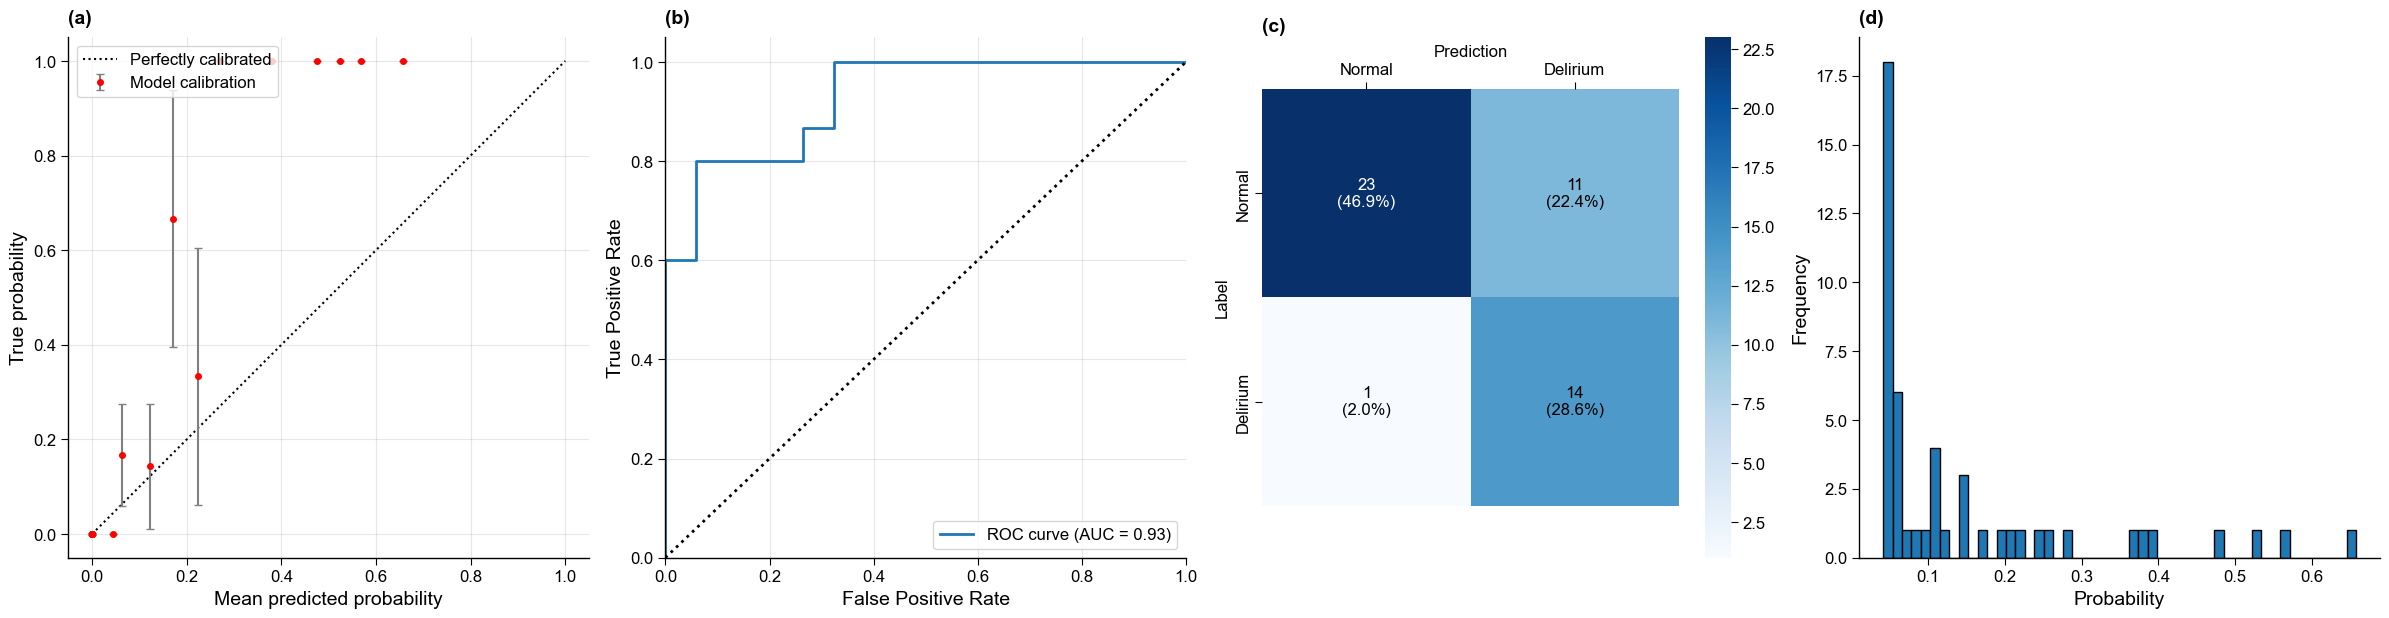

In [15]:
#Inference
train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

train_mask = np.isin(ID, train_ids)
X_train = X_normalized[train_mask]
y_train = Y_normalized[train_mask]

del X_normalized
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
a_train = A[train_mask]
s_train = S[train_mask]
p_train = P[train_mask].copy()
ID_train = ID[train_mask]
valid_indices = ~np.isnan(p_train)
filtered_y_train = y_train[valid_indices]
filtered_p_train = p_train[valid_indices]
Youden_p = youden(filtered_y_train, filtered_p_train)
orig_train_dataset = ChunkedDataset(X_train, a_train, s_train, y_train)
orig_train_loader = DataLoader(orig_train_dataset, batch_size=BATCH)
train_label_0 = np.sum(y_train[:, None] == 0)
train_label_1 = np.sum(y_train[:, None] == 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedGCNCNN(adj=adj).to(device)
X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
models = []
calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500, logodds_scale=False)
checkpoint = torch.load(f'final_model_full_training.pth')
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
models.append(model)

train_preds_all_models = []
train_targets = []

with torch.no_grad():
    train_pbar = tqdm(orig_train_loader, desc=f'[Train]')
    for inputs, age, sex, targets in train_pbar:
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        batch_preds = []
        for model in models:
            model.eval()
            outputs = model(inputs, age, sex, adj)
            batch_preds.append(outputs.detach().cpu().numpy())
        train_preds_all_models.extend(batch_preds[0].ravel())
        train_targets.extend(targets.detach().cpu().numpy())
train_preds = np.array(train_preds_all_models).ravel()
train_targets = np.array(train_targets).ravel()
Youden = youden(train_targets, train_preds)
calib.fit(train_preds, train_targets)

#with open('calibration.pkl', 'wb') as f:
#    pickle.dump(calib, f)
#np.save('youden.npy', Youden)
print(f'Youden Index : {Youden:.3f}')
del orig_train_loader
for test_ids_file in ['test_ids.npy','test_ids_1.npy', 'test_ids_2.npy']:
    test_ids = np.load(test_ids_file, allow_pickle=True)
    test_mask = np.isin(ID, test_ids)
    X_test = X_normalized[test_mask] 
    y_test = Y_normalized[test_mask]
    a_test = A[test_mask]
    s_test = S[test_mask]
    p_test = P[test_mask].copy()
    
    test_dataset = ChunkedDataset(X_test, a_test, s_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH)
    del test_dataset
    
    test_label_0 = np.sum(y_test[:, None] == 0)
    test_label_1 = np.sum(y_test[:, None] == 1)
    print(f"Test set - Label 0: {test_label_0}, Label 1: {test_label_1}")
    
    test_preds_all_models = []
    test_targets = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'[Test]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            batch_preds = []
            for model in models:
                model.eval()
                outputs = model(inputs, age, sex, adj)
                batch_preds.append(outputs.detach().cpu().numpy())
            test_preds_all_models.extend(batch_preds[0].ravel())
            test_targets.extend(targets.detach().cpu().numpy())
    test_preds = np.array(test_preds_all_models)
    test_targets = np.array(test_targets)

    valid_indices = ~np.isnan(p_test)
    filtered_test_preds = test_preds[valid_indices]
    filtered_p_test = p_test[valid_indices]
    test_ids_expanded = FILE[test_mask]
    test_preds = calib.calibrate(test_preds)
    unique_test_ids = np.unique(test_ids_expanded)
    averaged_test_preds = []
    averaged_test_targets = []
    averaged_p_test = []

    for test_id in unique_test_ids:
        id_indices = np.where(test_ids_expanded == test_id)[0]
        if len(id_indices) > 0:
            id_preds = test_preds[id_indices]
            id_p_test = p_test[id_indices]
            averaged_test_preds.append(np.mean(id_preds))
            averaged_p_test.append(np.nanmean(id_p_test))
            averaged_test_targets.append(test_targets[id_indices[0]])

    y_test = np.array(averaged_test_targets).ravel()
    y_test_proba = np.array(averaged_test_preds)
    p_test_mean = np.array(averaged_p_test)
    valid_indices = ~np.isnan(p_test_mean)
    filtered_y_test_proba = y_test_proba[valid_indices]
    filtered_y_test = y_test[valid_indices]
    filtered_y_pred_test = (filtered_y_test_proba > Youden).astype(int)
    #np.save(f'y_test_proba_{test_ids_file}', filtered_y_test_proba)
    draw_model_evaluation_plots(filtered_y_test, filtered_y_test_proba, filtered_y_pred_test, n_bins=20)
    torch.cuda.empty_cache()
    gc.collect()
    del test_loader

## Logistic Regression, ML

In [2]:
train_ids = np.load('train_ids_5.npy', allow_pickle=True)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

train_mask = np.isin(ID, train_ids)
train_files = FILE[train_mask]
unique_train_files = np.unique(train_files)
y_test_proba_test_ids = np.load('y_test_proba_test_ids.npy')
test_ids = np.load('test_ids.npy', allow_pickle=True)
test_mask = np.isin(ID, test_ids)
test_files = FILE[test_mask]
p_test = P[test_mask].copy()
valid_indices = ~np.isnan(p_test)
filtered_test_files = test_files[valid_indices]
test_ids_expanded = FILE[test_mask]
unique_test_ids = np.unique(test_ids_expanded)
final_file_ids = []
for test_id in unique_test_ids:
    id_indices = np.where(test_ids_expanded == test_id)[0]
    if len(id_indices) > 0:
        id_p_test = p_test[id_indices]
        if not np.all(np.isnan(id_p_test)):
            final_file_ids.append(test_id)
unique_test_files = np.array(final_file_ids)
##################################################################################
x2= pd.read_csv('delirium_old.csv', encoding='cp949', encoding_errors='ignore')
x1= pd.read_csv('eeg_rid_supreme_sampled.csv')
sex_mapping = dict(zip(x2['연구별 환자 ID'], x2['성별']))
x1['sex'] = x1['hid'].map(sex_mapping)
x1['sex'] = x1['sex'].map({'M': 1, 'F': 0})
x1['filename_str'] = x1['filename'].astype(str)
unique_test_files_str = [str(file) for file in unique_test_files]
test_mask = x1['filename_str'].isin(unique_test_files_str)
x_test = x1[test_mask].copy()
file_order = {filename: i for i, filename in enumerate(unique_test_files_str)}
x_test['file_order'] = x_test['filename_str'].map(file_order)
x_test = x_test.sort_values('file_order').drop(['file_order', 'filename_str'], axis=1)
x_test = x_test.reset_index(drop=True)
unique_train_files_str = [str(file) for file in unique_train_files]
train_mask = x1['filename_str'].isin(unique_train_files_str)
x_train = x1[train_mask].copy()
train_file_order = {filename: i for i, filename in enumerate(unique_train_files_str)}
x_train['file_order'] = x_train['filename_str'].map(train_file_order)
x_train = x_train.sort_values('file_order').drop(['file_order', 'filename_str'], axis=1)
x_train = x_train.reset_index(drop=True)
x1 = x1.drop('filename_str', axis=1)
y_test_proba_test_ids = np.load('y_test_proba_test_ids.npy')
x_test['y_test_proba_delphi'] = y_test_proba_test_ids
y_test_proba_SR = np.load('y_test_proba_SR.npy')
x_test['y_test_proba_SR'] =y_test_proba_SR
#############################################################################
x_train = process_vital_files(x_train)
x_test = process_vital_files(x_test)
columns_to_check = ['sr_auc', 'sr_duration', 'psi_duration']
x_train = x_train.dropna(subset=columns_to_check)
x_test = x_test.dropna(subset=columns_to_check)

x_train.to_csv('eeg_rid_supreme_train_5_ml.csv', index=False)
x_test.to_csv('eeg_rid_supreme_test_ml.csv', index=False)

Processing files:   0%|          | 0/953 [00:00<?, ?it/s]

Processing files:   0%|          | 0/2363 [00:00<?, ?it/s]

In [ ]:
x_train = pd.read_csv('eeg_rid_supreme_train_5_ml.csv')
models = {
    'xgb': create_objective_function('xgb', xgb.XGBClassifier, xgb_params),
    'lgb': create_objective_function('lgb', lgb.LGBMClassifier, lgb_params),
    'rf': create_objective_function('rf', RandomForestClassifier, rf_params),
    'gb': create_objective_function('gb', GradientBoostingClassifier, gb_params)
}
for model_name, objective_func in models.items():
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective_func(trial, x_train), n_trials=1000)

DELPHI-EEG AUROC: 0.869, Delong's test P = 0.005

========== Eval for LR ==========
AUROC 0.733 (95% CI: 0.623-0.827)
AUPRC 0.014 (95% CI: 0.007-0.027)
F1 Score 0.028 (95% CI: 0.012-0.047)
Test Accuracy 0.736 (95% CI: 0.718-0.754)
Brier Score 0.034 (95% CI: 0.031-0.038)
ICI 0.123 (95% CI: 0.117-0.129)


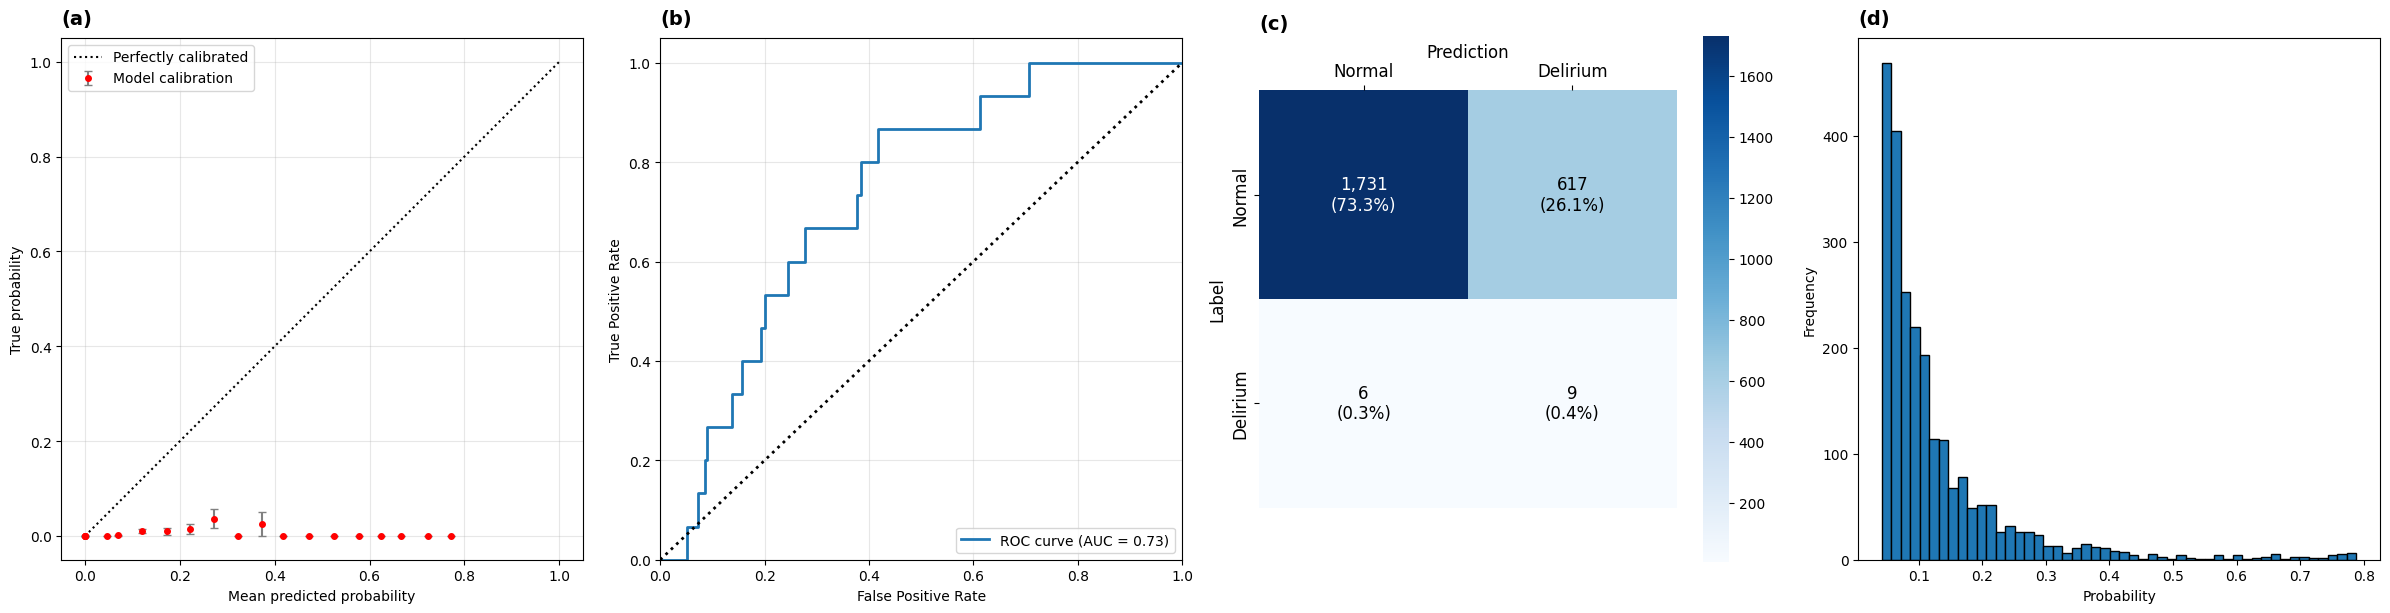


========== Eval for XGB ==========
AUROC 0.809 (95% CI: 0.687-0.892)
AUPRC 0.025 (95% CI: 0.012-0.045)
F1 Score 0.035 (95% CI: 0.016-0.057)
Test Accuracy 0.746 (95% CI: 0.729-0.763)
Brier Score 0.036 (95% CI: 0.032-0.039)
ICI 0.112 (95% CI: 0.107-0.119)


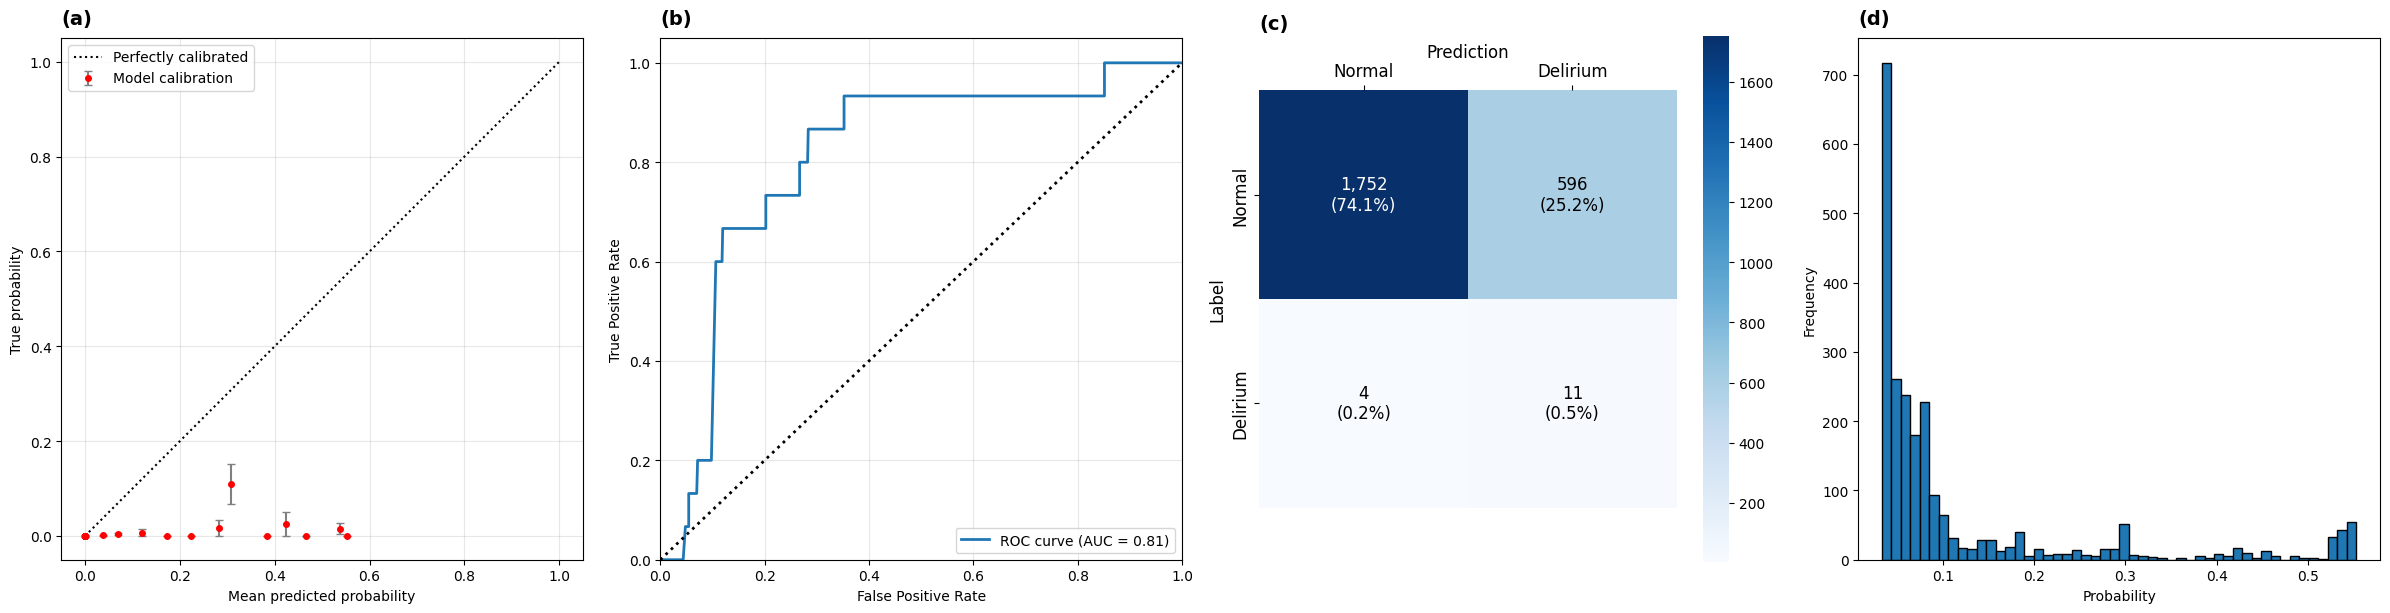

Delong's test P = 0.170


<Figure size 1200x800 with 0 Axes>

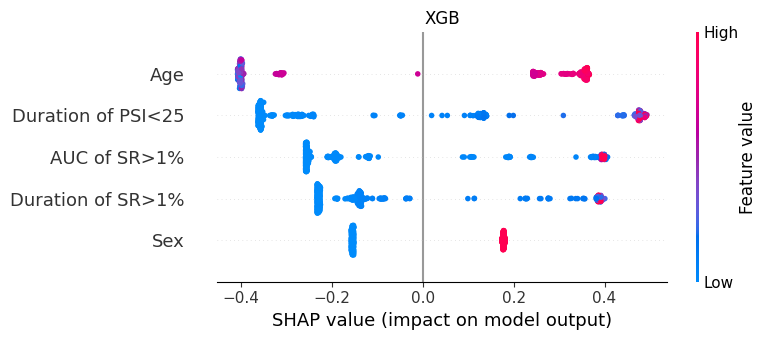


========== Eval for LGB ==========
AUROC 0.788 (95% CI: 0.679-0.871)
AUPRC 0.018 (95% CI: 0.009-0.033)
F1 Score 0.043 (95% CI: 0.018-0.071)
Test Accuracy 0.813 (95% CI: 0.796-0.827)
Brier Score 0.037 (95% CI: 0.034-0.041)
ICI 0.108 (95% CI: 0.102-0.115)


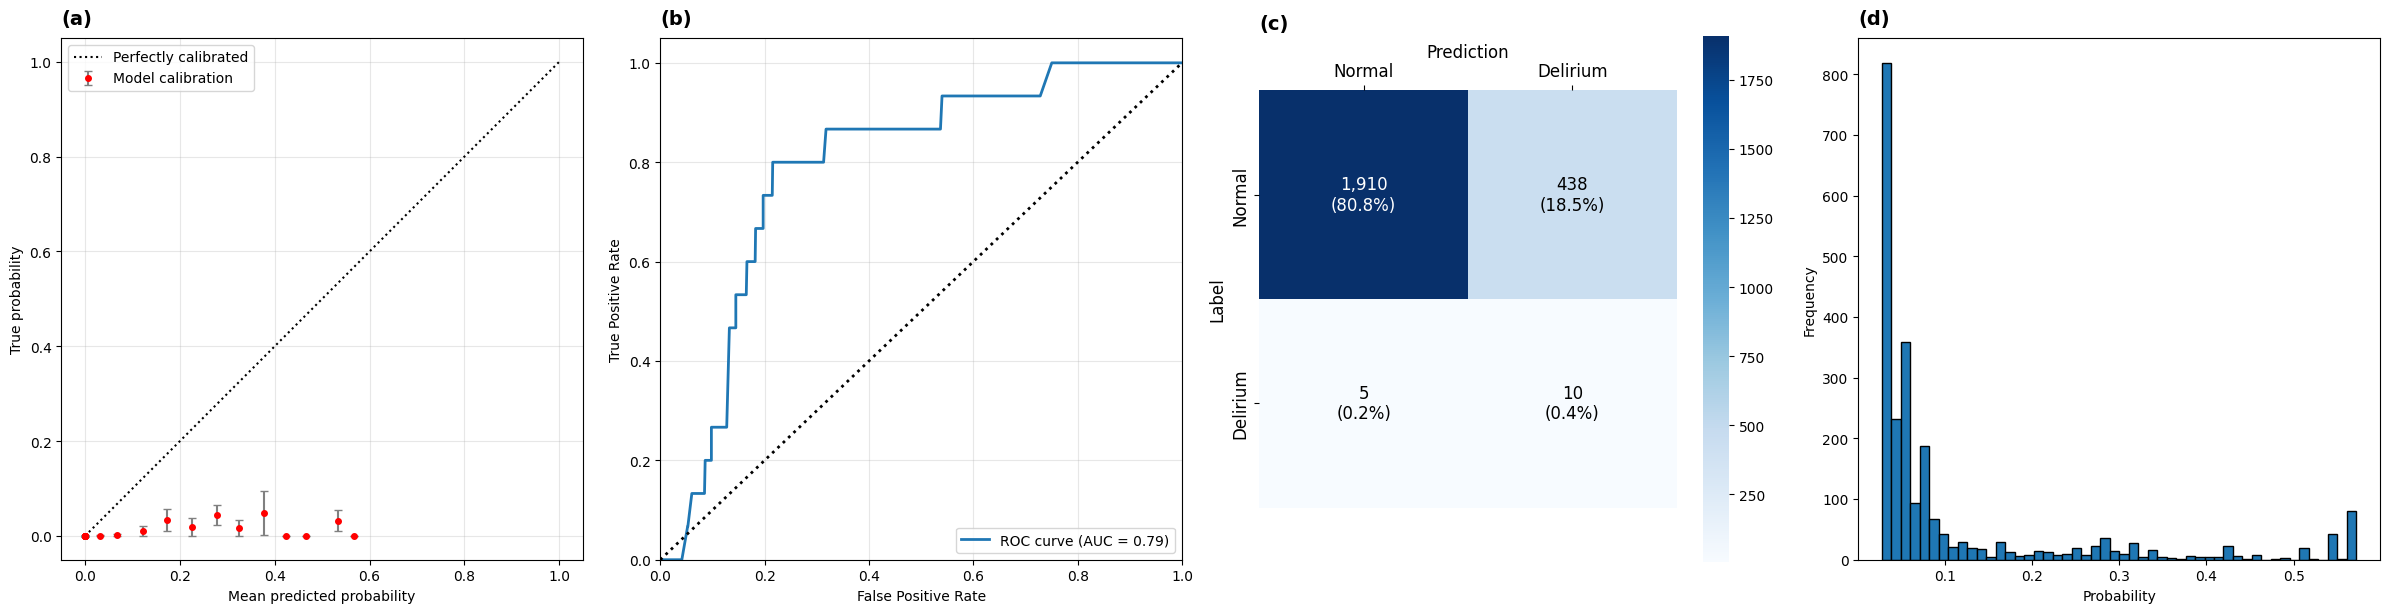

Delong's test P = 0.307


<Figure size 1200x800 with 0 Axes>

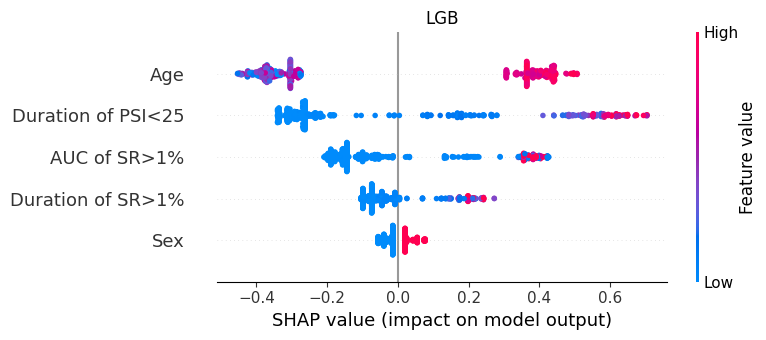


========== Eval for RF ==========
AUROC 0.829 (95% CI: 0.702-0.925)
AUPRC 0.035 (95% CI: 0.015-0.080)
F1 Score 0.032 (95% CI: 0.015-0.050)
Test Accuracy 0.665 (95% CI: 0.646-0.684)
Brier Score 0.037 (95% CI: 0.033-0.041)
ICI 0.106 (95% CI: 0.100-0.113)


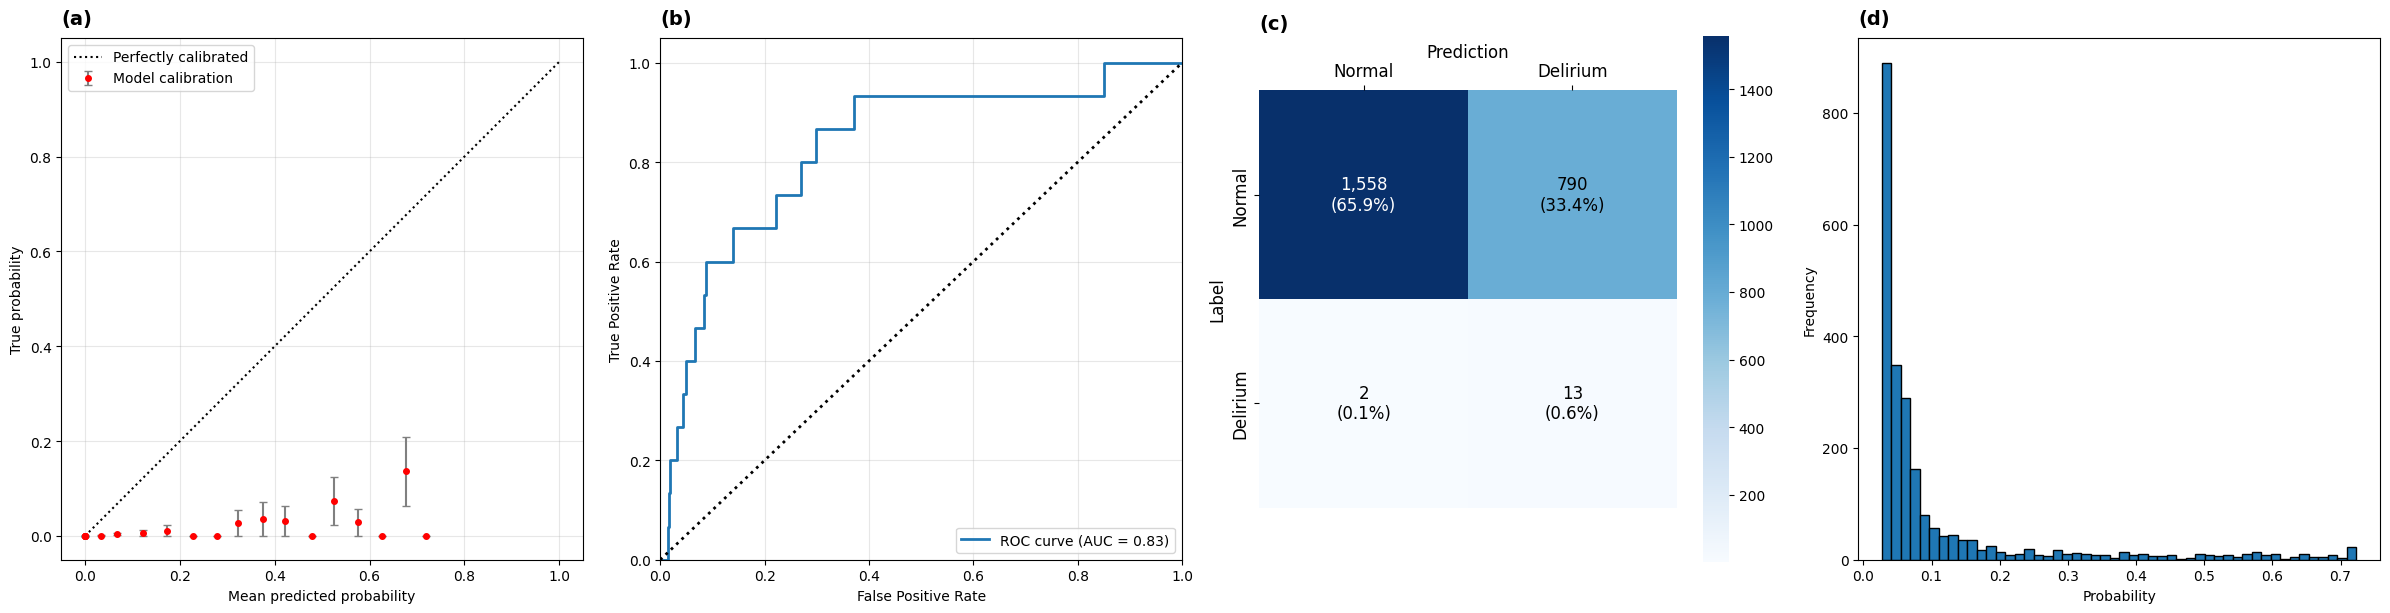

Delong's test P = 0.096


  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

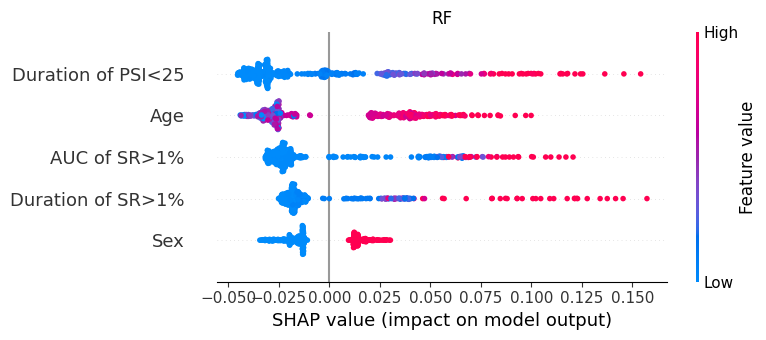


========== Eval for GB ==========
AUROC 0.790 (95% CI: 0.668-0.881)
AUPRC 0.019 (95% CI: 0.010-0.039)
F1 Score 0.039 (95% CI: 0.012-0.069)
Test Accuracy 0.853 (95% CI: 0.838-0.867)
Brier Score 0.047 (95% CI: 0.041-0.053)
ICI 0.093 (95% CI: 0.086-0.101)


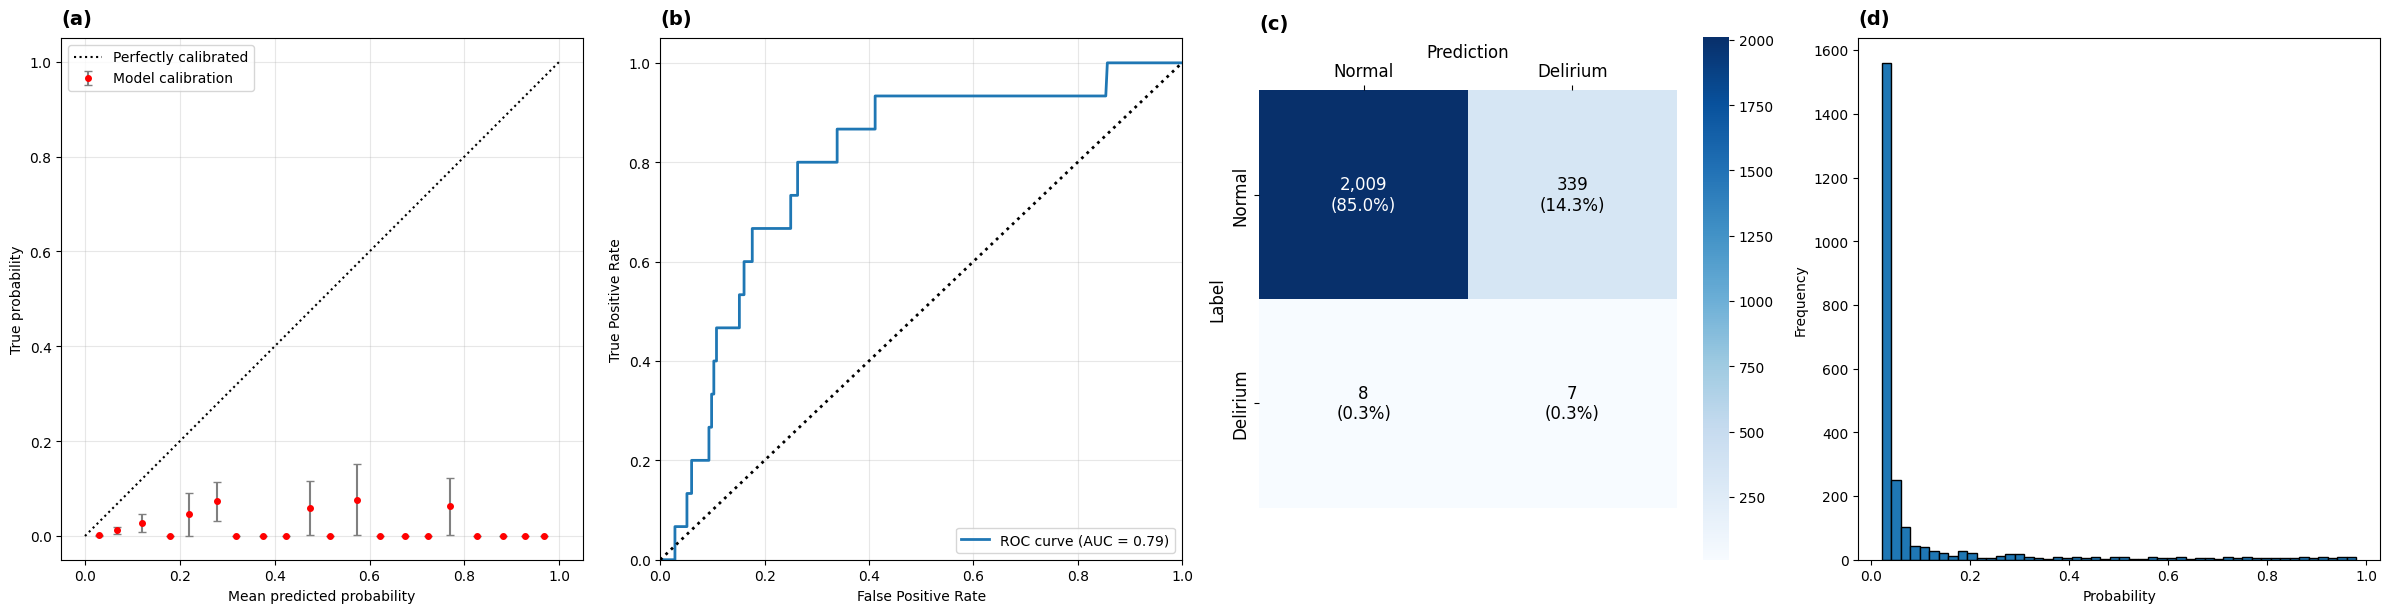

Delong's test P = 0.294


  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

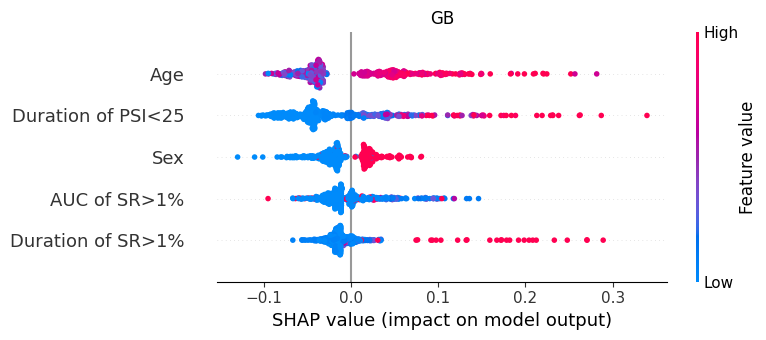

In [11]:
x_train = pd.read_csv('eeg_rid_supreme_train_5_ml.csv')
x_test = pd.read_csv('eeg_rid_supreme_test_ml.csv')
X_train = x_train[features]
y_train = x_train['label']
X_test = x_test[features]
y_test = x_test['label']

lr_model = LogisticRegression(random_state=SEED)
lr_model.fit(X_train, y_train)
x_test['y_test_proba_lr'] = lr_model.predict_proba(X_test)[:, 1]
x_train['y_test_proba_lr'] = lr_model.predict_proba(X_train)[:, 1]
lr_auroc = roc_auc_score(y_test, x_test['y_test_proba_lr'])

trained_models = {}
for model_name, config in model_configs.items():
    with open(f'best_params_{model_name}.json', 'r') as f:
        best_params = json.load(f)
    model = config['class'](**best_params)
    model.fit(X_train, y_train)
    x_test[config['column']] = model.predict_proba(X_test)[:, 1]
    x_train[config['column']] = model.predict_proba(X_train)[:, 1]
    trained_models[model_name] = model

xgb_auroc = roc_auc_score(y_test, x_test['y_test_proba_xgb'])
lgb_auroc = roc_auc_score(y_test, x_test['y_test_proba_lgb'])
rf_auroc = roc_auc_score(y_test, x_test['y_test_proba_rf'])
gb_auroc = roc_auc_score(y_test, x_test['y_test_proba_gb'])
delphi_auroc = roc_auc_score(y_test, x_test['y_test_proba_delphi'])

print(f"DELPHI-EEG AUROC: {delphi_auroc:.3f}, Delong's test P = {delong_roc_test(y_test, x_test['y_test_proba_delphi'], x_test['y_test_proba_lr'])[0][0]:.3f}")

y_test = y_test.ravel()
for model_name in ['lr','xgb', 'lgb', 'rf', 'gb']:
    print(f"\n========== Eval for {model_name.upper()} ==========")
    col_name = f'y_test_proba_{model_name}'
    
    Youden = youden(y_train, x_train[col_name])
    calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500, logodds_scale=False)
    calib.fit(x_train[col_name], y_train)
    y_test_proba = x_test[col_name].ravel()
    y_pred_test = (y_test_proba > Youden).astype(int).ravel()
    y_test_proba = calib.calibrate(y_test_proba)
    draw_model_evaluation_plots(y_test, y_test_proba, y_pred_test, n_bins=20)

    if model_name =='lr':
        continue
    print(f"Delong's test P = {delong_roc_test(y_test, y_test_proba, x_test['y_test_proba_lr'].ravel())[0][0]:.3f}")

    model = trained_models[model_name]
    plt.figure(figsize=(12, 8))
    X_test_sample = X_test.sample(n=500, random_state=42)
    if model_name == 'xgb' or model_name == 'lgb':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list):  
            shap_values = shap_values[1]  
    else:
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    plt.figure(figsize=(12, 8))
    X_test_display = X_test_sample.copy()
    feature_name_mapping = {
        'psi_duration': 'Duration of PSI<25',
        'sr_auc': 'AUC of SR>1%',
        'sr_duration': 'Duration of SR>1%',
        'age': 'Age',
        'sex': 'Sex'
    }
    X_test_display = X_test_display.rename(columns=feature_name_mapping)
    shap.summary_plot(shap_values, X_test_display, show=False)
    plt.title(f"{model_name.upper()}")
    plt.tight_layout()
    plt.show()

## Statistics/ Explainability

In [ ]:
x1 = pd.read_csv('eeg_rid_supreme_labelled_raw.csv') # label, exclude, p,c
x1['label']= ((x1['label_p']==1)|(x1['label_c']==1)).astype(int)
x1['exclude']=((x1['exclude_p']==1)|(x1['exclude_c']==1)).astype(int)
x1['exclude_both']= ((x1['exclude_p']==1)&(x1['exclude_c']==1)).astype(int)
x2 = pd.read_csv('eeg_rid_supreme_labelled.csv')

print(f"====Eligible Criteria: {x1['label'].value_counts().sum()}")
print(x1['label'].value_counts())
print()
print(f"====Exclusion:{x1['exclude'].value_counts()[1]}")
print(f"Preoperative anti-psychotics:{x1['exclude_p'].value_counts()[1]-x1['exclude_both'].value_counts()[1]}")
print(f"Preoperative NP consultion:{x1['exclude_c'].value_counts()[1]-x1['exclude_both'].value_counts()[1]}")
print(f"Both:{x1['exclude_both'].value_counts()[1]}")
print()
print(f'====Final labels: {x2["label"].value_counts().sum()}')
print(x2['label'].value_counts())
print()

with open('train_files.pkl', 'rb') as f:
    train_files = pickle.load(f)
x2_d_1 = x2[x2['filename'].isin(train_files)]
print(f"====Initial development set: {x2_d_1['label'].value_counts().sum()}")
print(x2_d_1['label'].value_counts())
print(f"====Undersampled development set")
x2_d_2 = pd.read_csv('eeg_rid_supreme_train_5.csv')
print(x2_d_2['label'].value_counts())
print(f"(+) samples: {x2_d_2.loc[x2_d_2['label']==1]['filename'].nunique()*30}")
print(f"(-) samples: {x2_d_2.loc[x2_d_2['label']==0]['filename'].nunique()*30}")
F_f = np.load('F_f.npy', allow_pickle=True)
print(f"====Development set")
mask = np.isin(F_f, x2_d_2.loc[x2_d_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_d_2.loc[x2_d_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print()

with open('test_files.pkl', 'rb') as f:
    test_files = pickle.load(f)
x2_t_1 = x2[x2['filename'].isin(test_files)]
print(f"====Test set:{x2_t_1['label'].value_counts().sum()}")
print(x2_t_1['label'].value_counts())
print(f"(+) samples: {x2_t_1['label'].value_counts()[1]*30}")
print(f"(-) samples: {x2_t_1['label'].value_counts()[0]*30}")
x2_t_2 = pd.read_csv('eeg_rid_supreme_test.csv')
print("====Original ratio test set")
mask = np.isin(F_f, x2_t_2.loc[x2_t_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_t_2.loc[x2_t_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print("====1:1 Undersampled test set")
test_ids_1 = np.load("test_ids_1.npy", allow_pickle=True)
x2_t_3 = x2_t_2[x2_t_2['hid'].isin(test_ids_1)]
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print("====2:1 Undersampled test set")
test_ids_1 = np.load("test_ids_2.npy", allow_pickle=True)
x2_t_3 = x2_t_2[x2_t_2['hid'].isin(test_ids_1)]
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==1]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(+) : {len(np.unique(F_f_1))} cases, {len(F_f_1)} samples")
mask = np.isin(F_f, x2_t_3.loc[x2_t_2['label']==0]['filename'].unique())
F_f_1 = F_f[mask]
print(f"(-) : {len(np.unique(F_f[mask]))} cases, {len(F_f[mask])} samples")
print()
x = pd.read_csv('eeg_rid_supreme_test.csv')
F_f = np.load('F_f.npy', allow_pickle=True)
x = x[x['filename'].isin(F_f)]
print(f"hid ratio of original ratio test set {x.loc[x['label']==0, 'hid'].nunique()/x.loc[x['label']==1, 'hid'].nunique():.0f}:1")

In [ ]:
x= pd.read_csv('eeg_rid_supreme_labelled.csv')

age_mean = x['age'].mean()
age_std = x['age'].std()
plt.figure(figsize=(10, 6))
plt.hist(x['age'], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of Age (Mean: {age_mean:.2f}, Std: {age_std:.2f})')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()
print(f"Mean age: {age_mean:.2f}")
print(f"Standard deviation of age: {age_std:.2f}")

x2= pd.read_csv('delirium_old.csv', encoding='cp949', encoding_errors='ignore')
sex_mapping = dict(zip(x2['연구별 환자 ID'], x2['성별']))
x['sex'] = x['hid'].map(sex_mapping)
x['sex'] = x['sex'].map({'M': 1, 'F': 0})
print(f"Proportion of male: {x['sex'].value_counts()[1]/x['sex'].value_counts().sum()}")

In [ ]:
x = pd.read_csv('eeg_rid_supreme_labelled.csv')
file_ages = {row['filename']: row['age'] >= 65 for _, row in x.iterrows()}
file_labels = {row['filename']: row['label'] for _, row in x.iterrows()}
elderly_positive = sum((row['age'] >= 65) & (row['label'] == 1) for _, row in x.iterrows())
elderly_negative = sum((row['age'] >= 65) & (row['label'] == 0) for _, row in x.iterrows())
younger_positive = sum((row['age'] < 65) & (row['label'] == 1) for _, row in x.iterrows())
younger_negative = sum((row['age'] < 65) & (row['label'] == 0) for _, row in x.iterrows())
contingency_table = np.array([
    [elderly_positive, elderly_negative],
    [younger_positive, younger_negative]
])

print("Contingency Table (by unique FILE):")
print(f"                  Positive  Negative")
print(f"Age >= 65:        {elderly_positive}      {elderly_negative}")
print(f"Age < 65:         {younger_positive}      {younger_negative}")

elderly_total = elderly_positive + elderly_negative
younger_total = younger_positive + younger_negative
print("\nPercentages:")
print(f"Age >= 65: Positive {elderly_positive/elderly_total*100:.2f}%, Negative {elderly_negative/elderly_total*100:.2f}%")
print(f"Age < 65:  Positive {younger_positive/younger_total*100:.2f}%, Negative {younger_negative/younger_total*100:.2f}%")

from scipy.stats import fisher_exact
odds_ratio, p_value = fisher_exact(contingency_table)
print(f"\nFisher's exact test results:")
print(f"Odds ratio: {odds_ratio:.4f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than {alpha}, suggesting a significant association between age group and label distribution.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than {alpha}, suggesting no significant association between age group and label distribution.")
df_contingency = pd.DataFrame({
    'Delirium': [elderly_positive, younger_positive],
    'Normal': [elderly_negative, younger_negative]
}, index=['≥65yrs', '<65yrs'])
df_percentage = df_contingency.copy()
for i in range(df_contingency.shape[0]):
    row_sum = df_contingency.iloc[i].sum()
    df_percentage.iloc[i] = df_contingency.iloc[i] / row_sum * 100
fontsize = 20
plt.figure(figsize=(8, 6))
ax = seaborn.heatmap(df_contingency, annot=False, fmt="d", cmap='Blues', annot_kws={"size": 16})
for i in range(df_contingency.shape[0]):
    for j in range(df_contingency.shape[1]):
        if i == 1 and j == 1 or i==0 and j==1:
            color = 'white'
        else:
            color = 'black'
        count = df_contingency.iloc[i, j]
        percent = df_percentage.iloc[i, j]
        text = f"{count:,}\n({percent:.1f}%)"
        ax.text(j+0.5, i+0.5, text, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=fontsize, color=color)
ax.set_xlabel('Label', fontsize=fontsize)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
plt.ylabel('Age Group', fontsize=fontsize)
plt.show()

In [ ]:
x = pd.read_csv('eeg_rid_supreme_labelled.csv')
x['interval'] = x[['label_p_interval','label_c_interval']].min(axis=1)
interval_stats = x['interval'].describe()
print("Statistics of interval:")
print(interval_stats)
plt.figure(figsize=(10, 6))
plt.hist(x['interval'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Histogram of Interval Values')
plt.xlabel('Interval')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

Processing test data:   0%|          | 0/3941 [00:00<?, ?it/s]

Delta relative
Spearman's ρ=0.244, p=0.000
β=0.343 [0.285, 0.400], α=0.353 [0.349, 0.358]
Theta relative
Spearman's ρ=0.085, p=0.000
β=0.104 [0.068, 0.141], α=0.131 [0.128, 0.134]
Alpha relative
Spearman's ρ=-0.603, p=0.000
β=-0.562 [-0.601, -0.523], α=0.153 [0.150, 0.156]


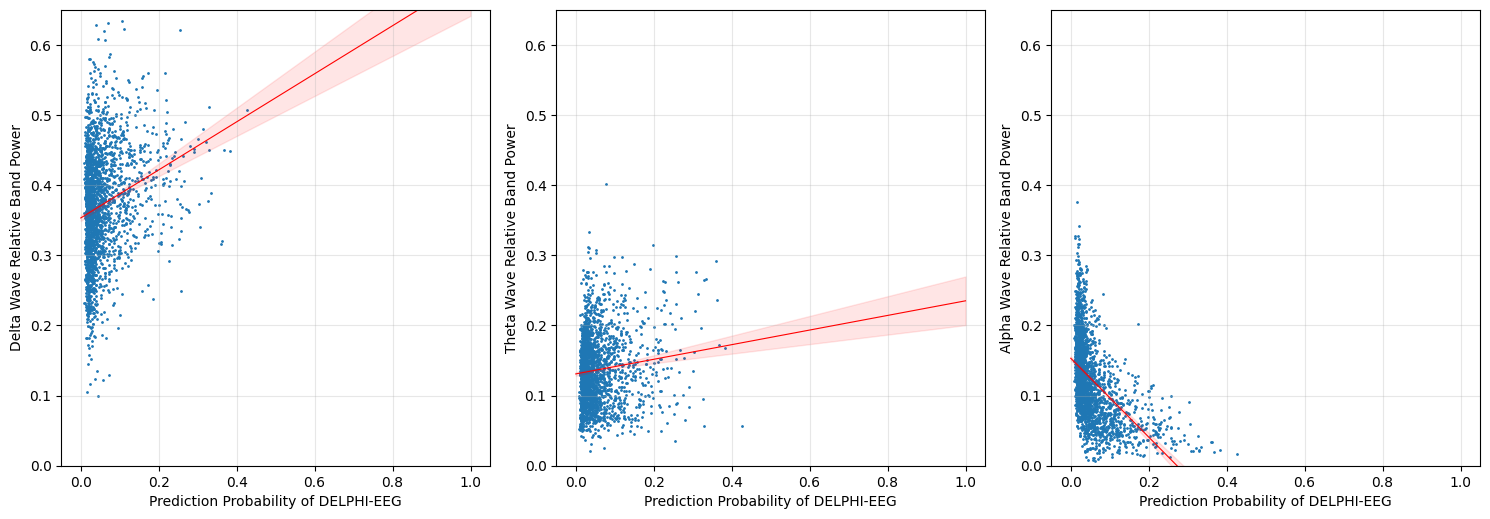

Evaluating baseline model performance...


[Test]:   0%|          | 0/3941 [00:00<?, ?it/s]

Baseline F1 for POD: 0.030
Ablating Slow (0.5-1 Hz) band (0.5-1 Hz)


  0%|          | 0/63049 [00:00<?, ?it/s]

[Test]:   0%|          | 0/3941 [00:00<?, ?it/s]

F1 for POD: 0.020 (Change: -34.297%)
Ablating Delta (1-4 Hz) band (1-4 Hz)


  0%|          | 0/63049 [00:00<?, ?it/s]

[Test]:   0%|          | 0/3941 [00:00<?, ?it/s]

F1 for POD: 0.020 (Change: -33.441%)
Ablating Theta (4-8 Hz) band (4-8 Hz)


  0%|          | 0/63049 [00:00<?, ?it/s]

[Test]:   0%|          | 0/3941 [00:00<?, ?it/s]

F1 for POD: 0.021 (Change: -29.981%)
Ablating Alpha (8-12 Hz) band (8-12 Hz)


  0%|          | 0/63049 [00:00<?, ?it/s]

[Test]:   0%|          | 0/3941 [00:00<?, ?it/s]

F1 for POD: 0.014 (Change: -53.060%)
Ablating Beta (12-30 Hz) band (12-30 Hz)


  0%|          | 0/63049 [00:00<?, ?it/s]

[Test]:   0%|          | 0/3941 [00:00<?, ?it/s]

F1 for POD: 0.018 (Change: -39.493%)


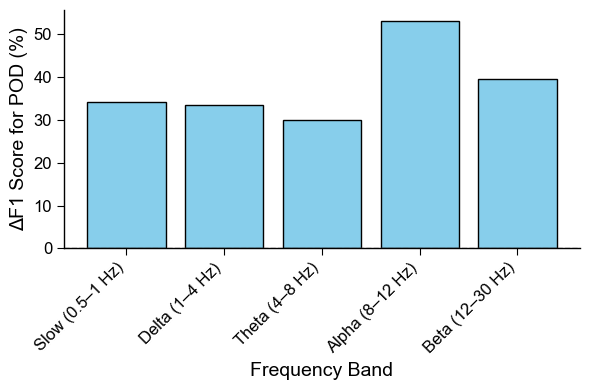

In [14]:
set_seeds()
run_frequency_analysis(
    model_path='final_model_full_training.pth',
    test_file='test_ids.npy',
)

X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')
youden_threshold = np.load('youden.npy')
with open('calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

test_file = 'test_ids.npy'
test_ids = np.load(test_file, allow_pickle=True)
test_mask = np.isin(ID, test_ids)
X_test = X_normalized[test_mask] 
y_test = Y_normalized[test_mask]
a_test = A[test_mask]
s_test = S[test_mask]
p_test = P[test_mask].copy()
file_ids_test = FILE[test_mask]
del X_normalized, ID, A, S, Y_normalized, test_ids, test_mask
clear_memory()
test_dataset = ChunkedDataset(X_test, a_test, s_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH)
checkpoint = torch.load('final_model_full_training.pth', map_location=device)
model = CombinedGCNCNN(adj=adj).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

print("Evaluating baseline model performance...")
baseline_f1 = evaluate_model(model, test_loader, device, youden_threshold, calib)
print(f"Baseline F1 for POD: {baseline_f1:.3f}")
# Parameters for FFT
fs = 80  # Sampling rate of 80 Hz (based on your SEGLEN = 120*80)
n_fft = 16384  # Increased FFT size to accommodate the larger input (power of 2 for efficiency)
# Define frequency bands for perturbation
frequency_bands = {
    'Slow (0.5-1 Hz)': (0.5, 1),
    'Delta (1-4 Hz)': (1, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-12 Hz)': (8, 12),
    'Beta (12-30 Hz)': (12, 30)
}
# Frequency band ablation on the original time series
# Store results for frequency band ablation
frequency_band_results = []
# Calculate frequency axis (in Hz)
freq_axis = np.fft.fftfreq(n_fft, 1/fs)[:n_fft//2]
# For each frequency band, create a copy of the model and zero out that band in the input data
for band_name, (low_freq, high_freq) in frequency_bands.items():
    print(f"Ablating {band_name} band ({low_freq}-{high_freq} Hz)")
    # Create a modified test dataset with the frequency band ablated
    X_test_modified = X_test.copy()
    # Get the frequency indices corresponding to this band
    low_idx = np.where(freq_axis >= low_freq)[0][0]
    high_idx = np.where(freq_axis <= high_freq)[0][-1]
    # Apply FFT to each channel of each sample, zero out the specified band, and convert back
    for i in tqdm(range(len(X_test_modified))):
        for channel in range(X_test_modified.shape[1]):
            # Get the channel data
            channel_data = X_test_modified[i, channel, :]
            # Apply window function (Hanning) to reduce spectral leakage
            windowed_data = channel_data * np.hanning(len(channel_data))
            # Zero-pad to n_fft points - make sure n_fft is larger than channel_data length
            padded_data = np.zeros(n_fft)
            padded_data[:len(channel_data)] = windowed_data
            # Compute FFT
            data_fft = fft(padded_data)
            # Create a mask that zeros out the specified frequency band
            mask = np.ones_like(data_fft)
            mask[low_idx:high_idx+1] = 0
            mask[n_fft-high_idx-1:n_fft-low_idx] = 0  # Mirror for negative frequencies
            # Apply the mask to the frequency response
            modified_fft = data_fft * mask
            # Convert back to time domain (inverse FFT)
            modified_data = np.real(ifft(modified_fft))
            # Update the data
            X_test_modified[i, channel, :] = modified_data[:len(channel_data)]
    
    # Create a new dataset and loader with the modified data
    modified_test_dataset = ChunkedDataset(X_test_modified, a_test, s_test, y_test)
    modified_test_loader = DataLoader(modified_test_dataset, batch_size=BATCH)
    # Evaluate the model with the modified data
    band_ablated_f1 = evaluate_model(model, modified_test_loader, device, youden_threshold, calib)
    # Calculate percent change in performance
    f1_change = ((band_ablated_f1 - baseline_f1) / baseline_f1) * 100
    print(f"F1 for POD: {band_ablated_f1:.3f} (Change: {f1_change:.3f}%)")
    
    # Store results
    frequency_band_results.append({
        'band_name': band_name,
        'f1_change': f1_change
    })

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.grid': False
})

# Define frequency bands for perturbation
frequency_bands = {
    'Slow (0.5–1 Hz)': (0.5, 1),
    'Delta (1–4 Hz)': (1, 4),
    'Theta (4–8 Hz)': (4, 8),
    'Alpha (8–12 Hz)': (8, 12),
    'Beta (12–30 Hz)': (12, 30)
}

# Visualize results
plt.figure(figsize=(6, 4))  
band_names = list(frequency_bands.keys())
f1_changes = [result['f1_change'] for result in frequency_band_results]
changes = [-f1_change for f1_change in f1_changes]
bars = plt.bar(range(len(band_names)), changes, color='skyblue', edgecolor='black')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xticks(range(len(band_names)), band_names, rotation=45, ha='right')
plt.ylabel('ΔF1 Score for POD (%)')
plt.xlabel('Frequency Band')
plt.tight_layout()
plt.show()